<a href="https://colab.research.google.com/github/lamsalshrawan/Thesis_RMC_PRnet/blob/main/PRnet_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Import necessary Libraries
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, label_binarize
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files  # For downloading the predictions


In [ ]:
# Load the Excel file from Google Drive
file_path = '/content/drive/My Drive/predictions23march_rmc.xlsx'  # Update the path if necessary
data = pd.read_excel(file_path)
print(data.columns)


Index(['Chainage', 'CRS', 'Torque', 'PRchd', 'Thrust', 'PRnet', 'RMR', 'RMC',
       'RMC_RF', 'RMC_SVM', 'SE', 'FPI', 'Lithology', 'Formation',
       'Weathering', 'Strength'],
      dtype='object')


In [ ]:
# Drop the "Chainage" column
data = data.drop(columns=[ 'RMR'])  # Keep only features

# Print the remaining columns to verify
print(data.columns)


Index(['Chainage', 'CRS', 'Torque', 'PRchd', 'Thrust', 'PRnet', 'RMC',
       'RMC_RF', 'RMC_SVM', 'SE', 'FPI', 'Lithology', 'Formation',
       'Weathering', 'Strength'],
      dtype='object')


In [ ]:
# Define features and target
X = data[['CRS', 'Torque','PRchd', 'Thrust','RMC']]  # Replace with actual feature names
y = data['PRnet']  # Replace with actual target column name


In [ ]:
# Label encoding for categorical columns
label_encoder = LabelEncoder()
X = X.copy()  # Avoid SettingWithCopyWarning
for col in ['RMC']:
    X[col] = label_encoder.fit_transform(X[col])

print(X.head())  # Check preprocessed data


   CRS  Torque  PRchd  Thrust  RMC
0  5.0     415    8.0    4118    1
1  4.5     387    7.3    5084    1
2  5.0     586    7.1    7345    1
3  5.5     407    7.8    6004    1
4  4.5     460    7.9    7152    1


In [ ]:
# Normalize features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
# 🔹 Use Best Hyperparameters from GridSearchCV
best_params = {
    "SVM": {'C': 40, 'gamma': 'auto', 'kernel': 'rbf'},
    "Decision Tree": {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5},
    "KNN": {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'},
    "Random Forest": {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
}

# Initialize models with best hyperparameters
models = {
    "SVM": SVR(**best_params["SVM"]),
    "Decision Tree": DecisionTreeRegressor(**best_params["Decision Tree"]),
    "KNN": KNeighborsRegressor(**best_params["KNN"]),
    "Random Forest": RandomForestRegressor(**best_params["Random Forest"])
}

# 🔹 Train and Evaluate Best Models on the Test Set
results = {
    "Model": [],
    "R²": [],
    "Adjusted R²": [],  # Added Adjusted R²
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "RRMSE": [],
    "MAPE": [],
    "MRE": [],
    "VAF": []
}

# Dictionary to store predictions for each model (on the entire dataset)
predictions_dict = {
    "Actual_PRnet": y.values  # Store actual PRnet values for the entire dataset
}

# Function to calculate Adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else np.nan

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions on the test set for evaluation
    y_pred_test = model.predict(X_test)

    # Compute Metrics (on the test set)
    r2 = r2_score(y_test, y_pred_test)
    n = len(y_test)  # Number of observations
    p = X_test.shape[1]  # Number of predictors/features
    adj_r2 = adjusted_r2(r2, n, p)  # Calculate Adjusted R²

    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    rrmse = rmse / np.mean(y_test) if np.mean(y_test) != 0 else np.nan
    mape = np.mean(np.abs((y_test - y_pred_test) / (y_test + 1e-10))) * 100
    mre = np.mean(np.abs(y_test - y_pred_test) / (np.abs(y_test) + np.abs(y_pred_test) + 1e-10)) * 100
    vaf = (1 - np.var(y_test - y_pred_test) / np.var(y_test)) * 100

    # Store Results (for test set evaluation)
    results["Model"].append(name)
    results["R²"].append(round(r2, 3))
    results["Adjusted R²"].append(round(adj_r2, 3))  # Add Adjusted R² to results
    results["MAE"].append(round(mae, 3))
    results["MSE"].append(round(mse, 3))
    results["RMSE"].append(round(rmse, 3))
    results["RRMSE"].append(round(rrmse, 3))
    results["MAPE"].append(round(mape, 3))
    results["MRE"].append(round(mre, 3))
    results["VAF"].append(round(vaf, 3))

    # Predictions on the entire dataset
    y_pred_all = model.predict(X_scaled)

    # Store predictions in the dictionary (for the entire dataset)
    predictions_dict[f"Predicted_PRnet_{name}"] = y_pred_all

# Convert results to a DataFrame and display (test set evaluation)
results_df = pd.DataFrame(results)
display(results_df)

,Model,R²,Adjusted R²,MAE,MSE,RMSE,RRMSE,MAPE,MRE,VAF
0,SVM,0.990,0.990,0.540,0.595,0.772,0.014,1.037,0.517,99.025
1,Decision Tree,0.980,0.980,0.756,1.234,1.111,0.020,1.461,0.725,97.980
2,KNN,0.965,0.964,1.042,2.147,1.465,0.027,2.021,0.998,96.494
3,Random Forest,0.974,0.974,0.846,1.558,1.248,0.023,1.661,0.819,97.445


In [ ]:
# 🔹 Evaluate Training and Testing Accuracy to Check for Overfitting
train_test_results = {
    "Model": [],
    "Train R²": [],
    "Test R²": [],
    "Train MAE": [],
    "Test MAE": [],
    "Train MSE": [],
    "Test MSE": [],
    "Train RMSE": [],
    "Test RMSE": []
}

for name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)

    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)

    train_test_results["Model"].append(name)
    train_test_results["Train R²"].append(round(train_r2, 3))
    train_test_results["Test R²"].append(round(test_r2, 3))
    train_test_results["Train MAE"].append(round(train_mae, 3))
    train_test_results["Test MAE"].append(round(test_mae, 3))
    train_test_results["Train MSE"].append(round(train_mse, 3))
    train_test_results["Test MSE"].append(round(test_mse, 3))
    train_test_results["Train RMSE"].append(round(train_rmse, 3))
    train_test_results["Test RMSE"].append(round(test_rmse, 3))

train_test_df = pd.DataFrame(train_test_results)
print("\nTraining vs. Testing Metrics (to Check for Overfitting):")
display(train_test_df)

print("\nOverfitting Analysis:")
for index, row in train_test_df.iterrows():
    r2_diff = row["Train R²"] - row["Test R²"]
    print(f"{row['Model']}:")
    print(f"  R² Difference (Train - Test): {r2_diff:.3f}")
    if r2_diff > 0.1:
        print("  - Potential overfitting: Training R² is significantly higher than Test R².")
    elif r2_diff > 0.05:
        print("  - Mild overfitting: Training R² is slightly higher than Test R².")
    else:
        print("  - No significant overfitting: Training and Test R² are close.")
    print(f"  RMSE Difference (Test - Train): {row['Test RMSE'] - row['Train RMSE']:.3f}")
    print()


Training vs. Testing Metrics (to Check for Overfitting):


,Model,Train R²,Test R²,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE
0,SVM,0.993,0.990,0.491,0.540,0.469,0.595,0.685,0.772
1,Decision Tree,0.995,0.980,0.441,0.756,0.351,1.234,0.592,1.111
2,KNN,1.000,0.965,0.000,1.042,0.000,2.147,0.000,1.465
3,Random Forest,1.000,0.974,0.000,0.846,0.000,1.558,0.001,1.248



Overfitting Analysis:
SVM:
  R² Difference (Train - Test): 0.003
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.087

Decision Tree:
  R² Difference (Train - Test): 0.015
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.519

KNN:
  R² Difference (Train - Test): 0.035
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 1.465

Random Forest:
  R² Difference (Train - Test): 0.026
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 1.247



In [ ]:
# 🔹 Evaluate Training and Testing Accuracy to Check for Overfitting
train_test_results = {
    "Model": [],
    "Train R²": [],
    "Test R²": [],
    "Train MAE": [],
    "Test MAE": [],
    "Train MSE": [],
    "Test MSE": [],
    "Train RMSE": [],
    "Test RMSE": []
}

for name, model in models.items():
    # Predictions on training set
    y_pred_train = model.predict(X_train)
    # Predictions on test set (already computed in your code)
    y_pred_test = model.predict(X_test)

    # Compute metrics for training set
    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)

    # Compute metrics for test set
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)

    # Store results
    train_test_results["Model"].append(name)
    train_test_results["Train R²"].append(round(train_r2, 3))
    train_test_results["Test R²"].append(round(test_r2, 3))
    train_test_results["Train MAE"].append(round(train_mae, 3))
    train_test_results["Test MAE"].append(round(test_mae, 3))
    train_test_results["Train MSE"].append(round(train_mse, 3))
    train_test_results["Test MSE"].append(round(test_mse, 3))
    train_test_results["Train RMSE"].append(round(train_rmse, 3))
    train_test_results["Test RMSE"].append(round(test_rmse, 3))

# Convert results to a DataFrame and display
train_test_df = pd.DataFrame(train_test_results)
print("\nTraining vs. Testing Metrics (to Check for Overfitting):")
display(train_test_df)

# 🔹 Interpretation of Overfitting
print("\nOverfitting Analysis:")
for index, row in train_test_df.iterrows():
    r2_diff = row["Train R²"] - row["Test R²"]
    print(f"{row['Model']}:")
    print(f"  R² Difference (Train - Test): {r2_diff:.3f}")
    if r2_diff > 0.1:
        print("  - Potential overfitting: Training R² is significantly higher than Test R².")
    elif r2_diff > 0.05:
        print("  - Mild overfitting: Training R² is slightly higher than Test R².")
    else:
        print("  - No significant overfitting: Training and Test R² are close.")
    print(f"  RMSE Difference (Test - Train): {row['Test RMSE'] - row['Train RMSE']:.3f}")
    print()


Training vs. Testing Metrics (to Check for Overfitting):


,Model,Train R²,Test R²,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE
0,SVM,0.993,0.990,0.491,0.540,0.469,0.595,0.685,0.772
1,Decision Tree,0.995,0.980,0.441,0.756,0.351,1.234,0.592,1.111
2,KNN,1.000,0.965,0.000,1.042,0.000,2.147,0.000,1.465
3,Random Forest,1.000,0.974,0.000,0.846,0.000,1.558,0.001,1.248



Overfitting Analysis:
SVM:
  R² Difference (Train - Test): 0.003
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.087

Decision Tree:
  R² Difference (Train - Test): 0.015
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.519

KNN:
  R² Difference (Train - Test): 0.035
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 1.465

Random Forest:
  R² Difference (Train - Test): 0.026
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 1.247



SHAP Summary Plot (Bar) - Random Forest


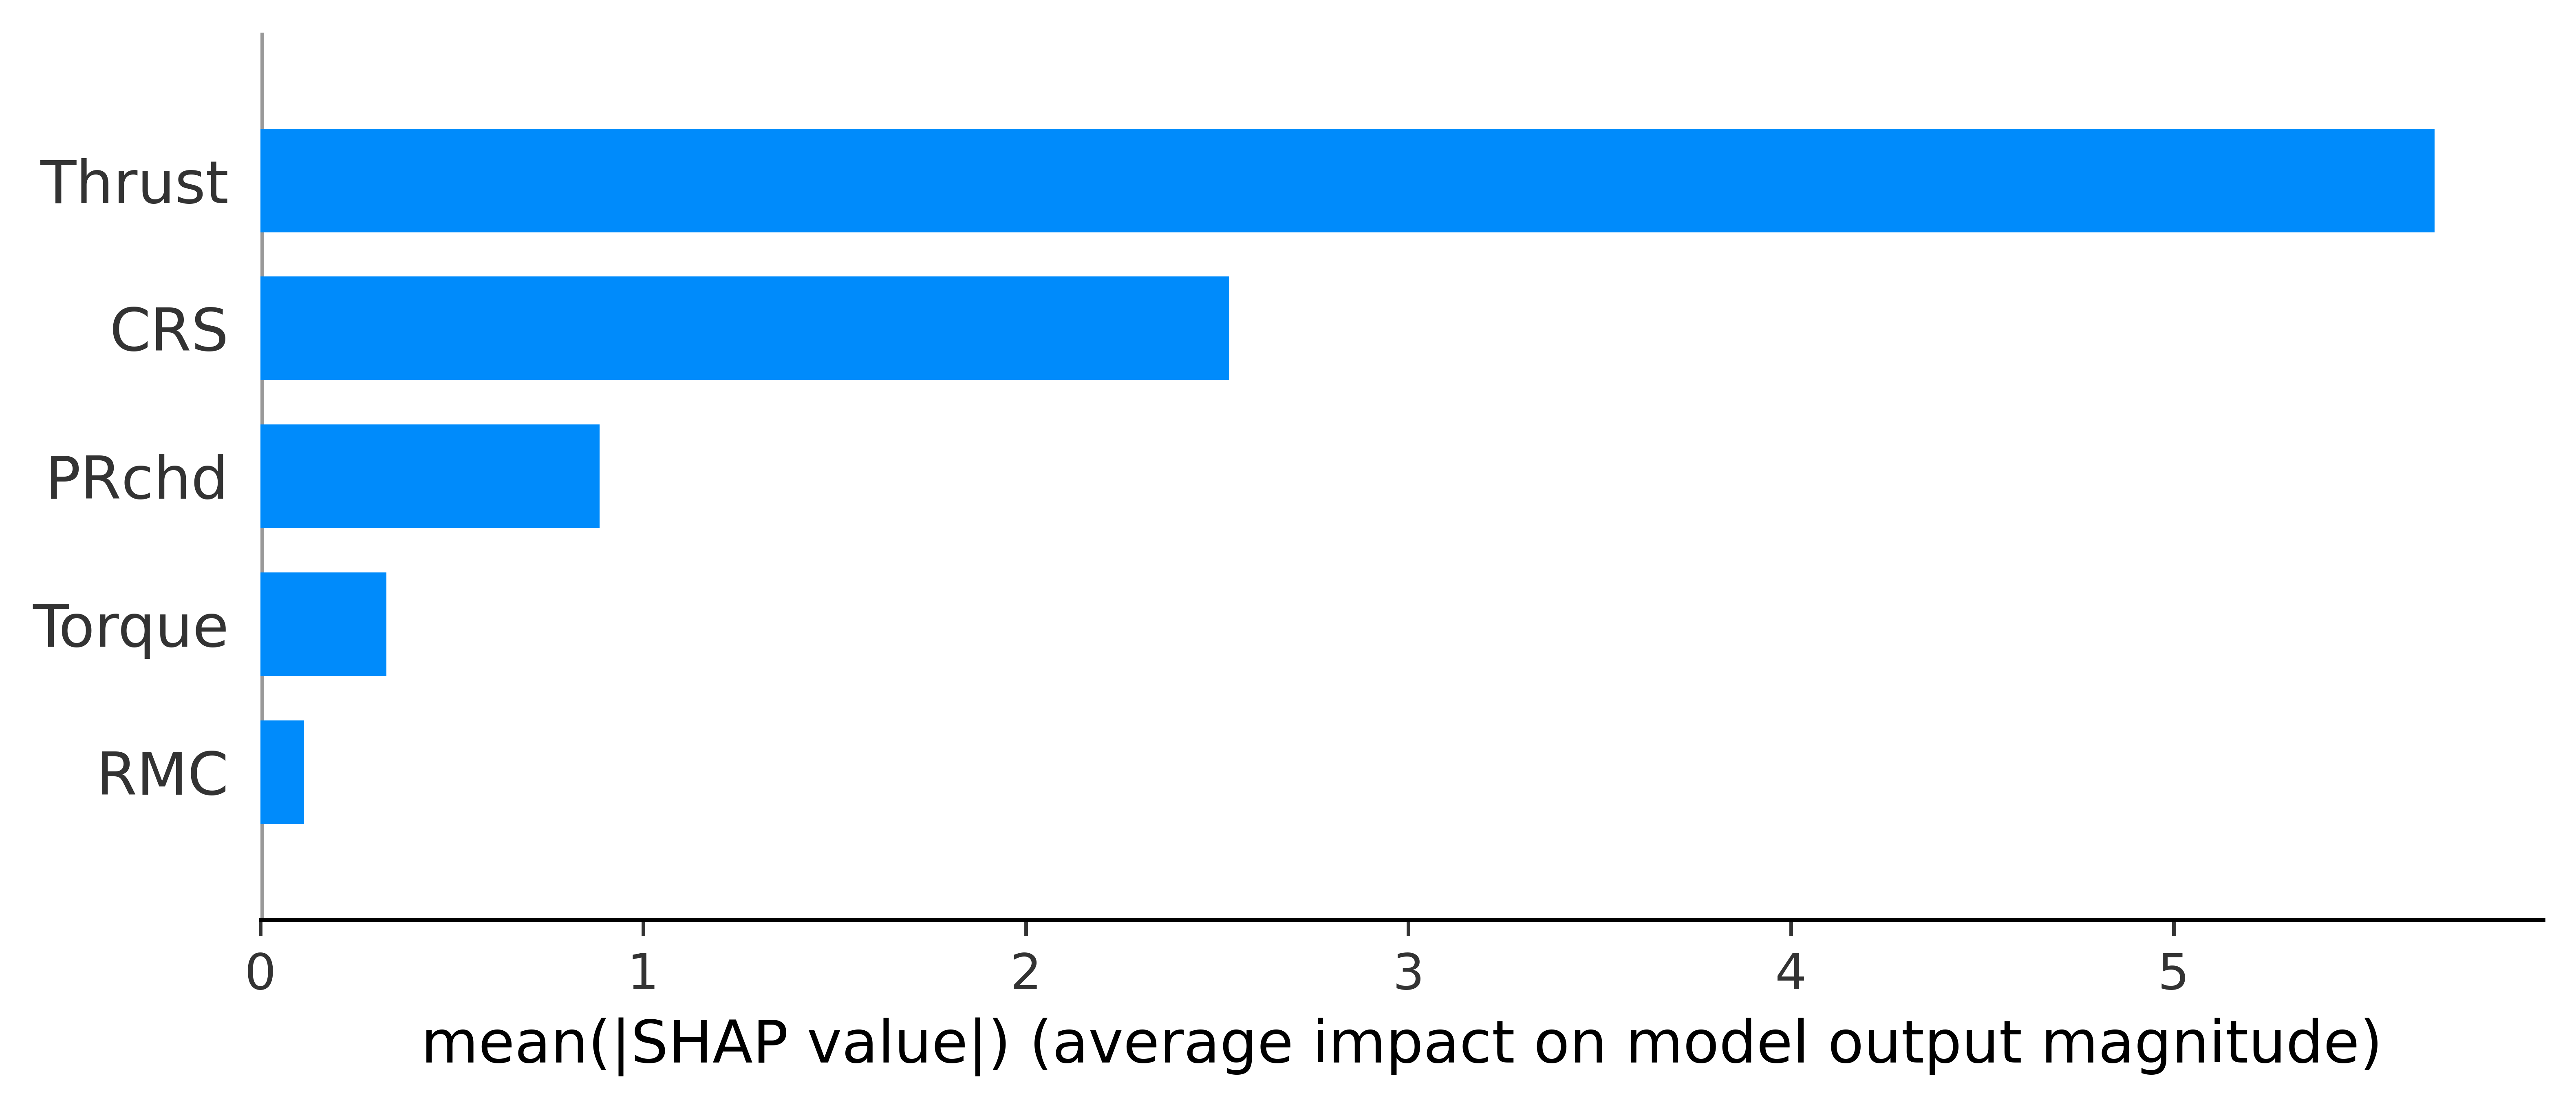

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


SHAP Summary Plot (Beeswarm) - Random Forest


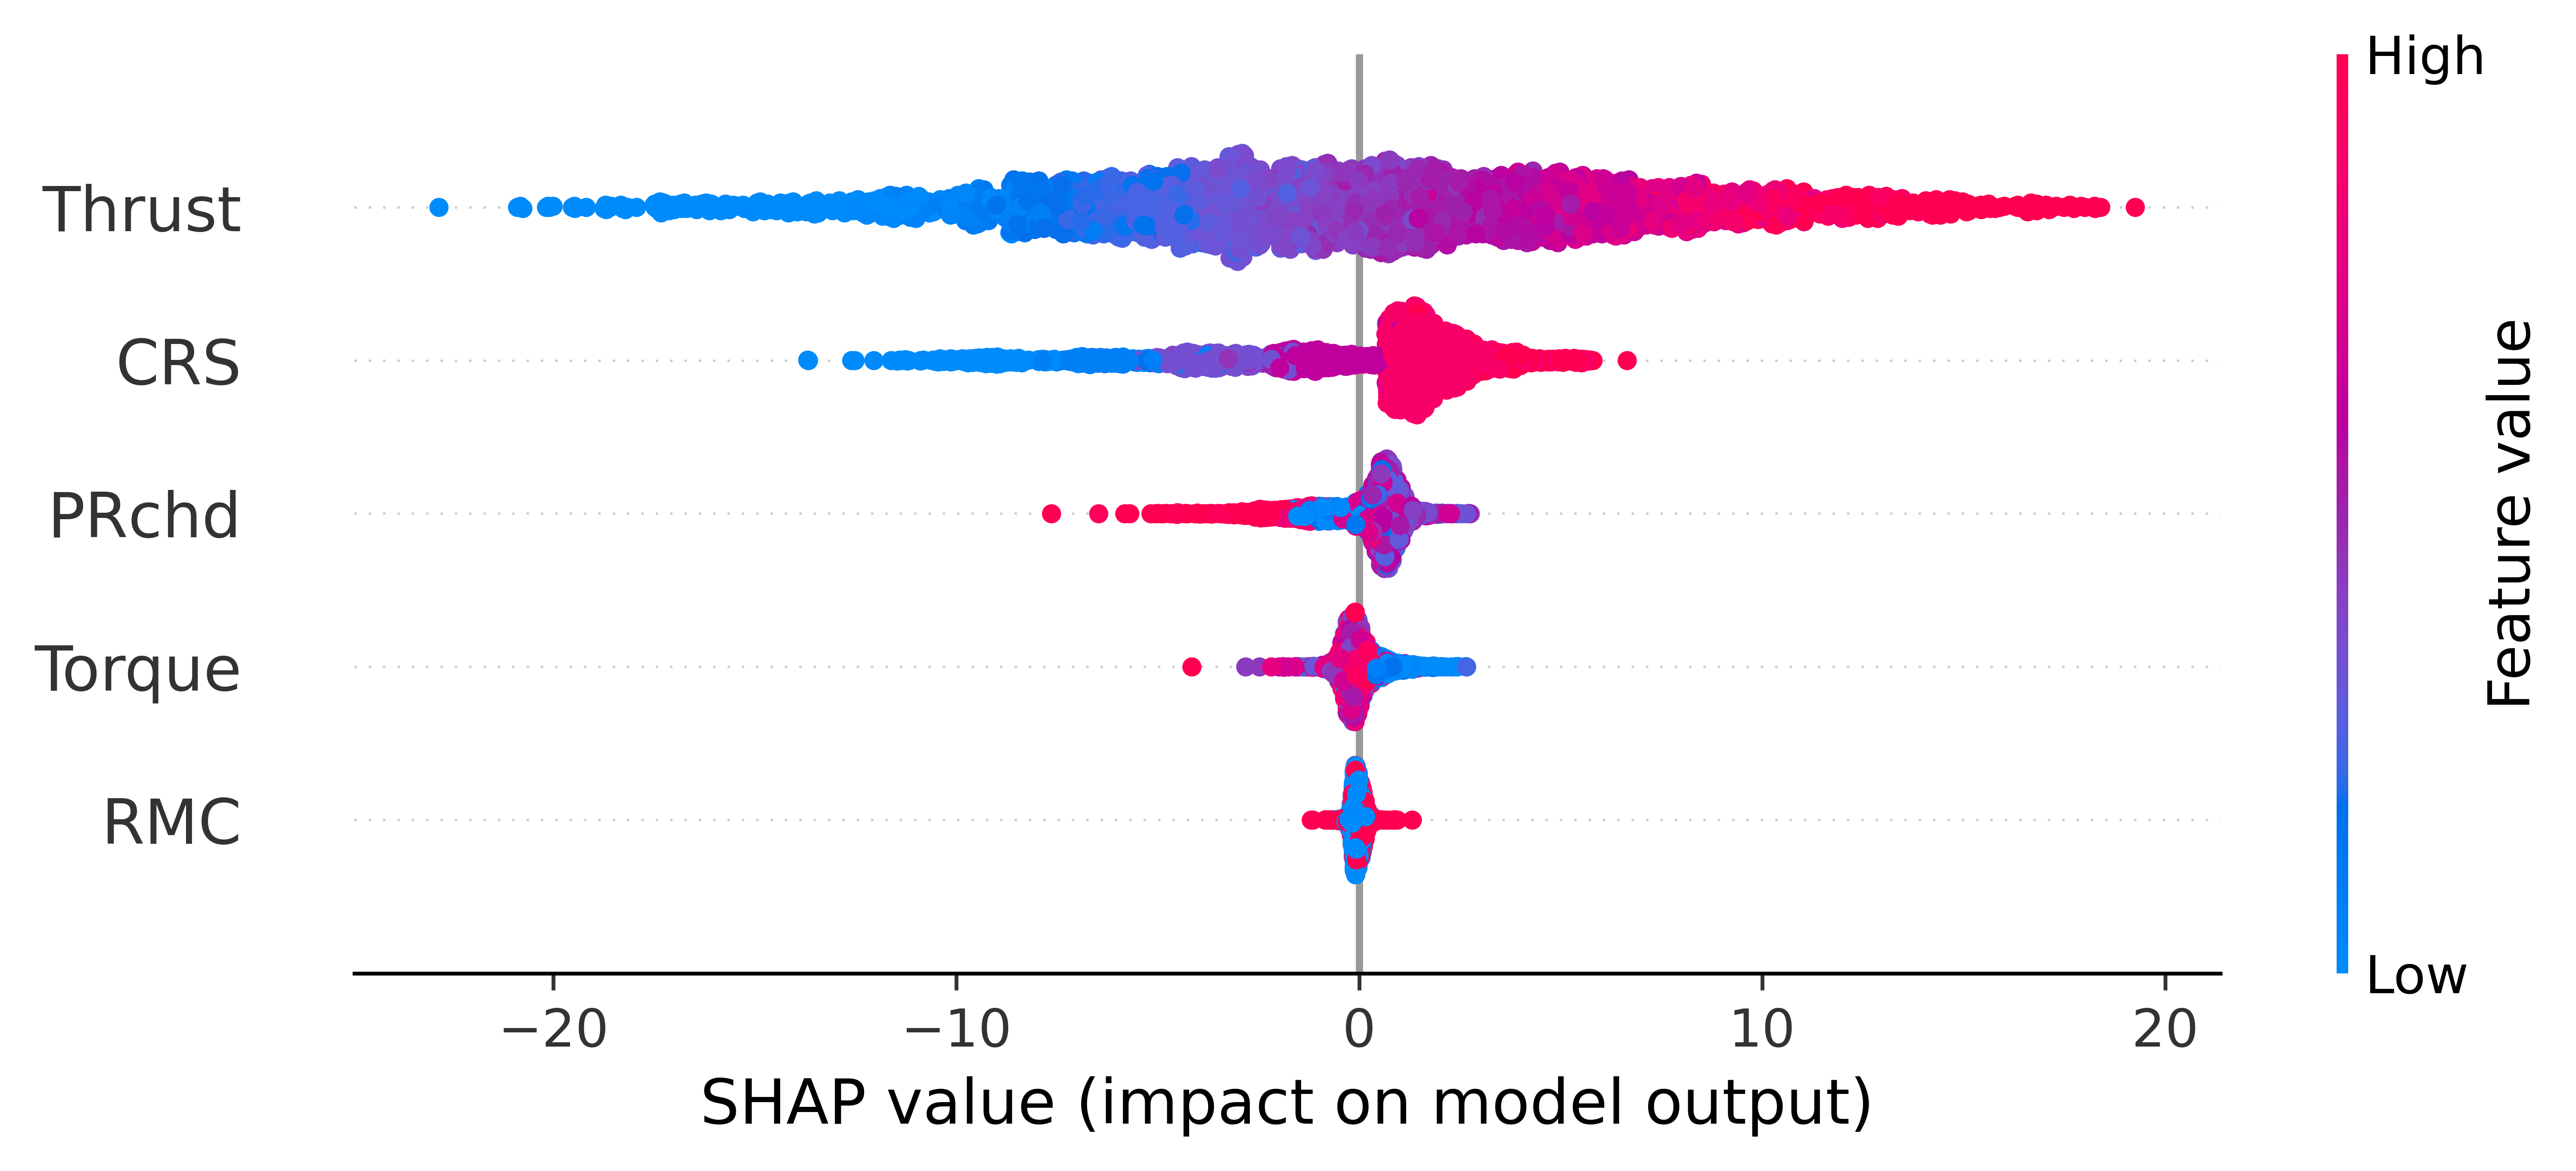

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🔹 SHAP Analysis on Random Forest Model #TRAIN SET
# Select the Random Forest model for SHAP analysis
model_rf = models['Random Forest']

# Create a SHAP explainer object for the Random Forest model
explainer = shap.TreeExplainer(model_rf)

# Calculate SHAP values for the entire dataset
shap_values = explainer.shap_values(X_scaled)

# Feature names for better readability in plots
feature_names = ['CRS', 'Torque', 'Thrust', 'PRchd', 'RMC']

# Summary plot (bar plot) for overall feature importance
print("SHAP Summary Plot (Bar) - Random Forest")
plt.figure(dpi=800)  # Set DPI for high resolution
shap.summary_plot(shap_values, X_scaled, feature_names=feature_names, plot_type="bar", show=False)
plt.savefig('shap_summary_bar_rf.png', dpi=800, bbox_inches='tight')
plt.show()
files.download('shap_summary_bar_rf.png')  # Download the file

# Detailed summary plot (beeswarm plot) for feature impact
print("\nSHAP Summary Plot (Beeswarm) - Random Forest")
plt.figure(dpi=800)  # Set DPI for high resolution
shap.summary_plot(shap_values, X_scaled, feature_names=feature_names, show=False)
plt.savefig('shap_summary_beeswarm_rf.png', dpi=800, bbox_inches='tight')
plt.show()
files.download('shap_summary_beeswarm_rf.png')  # Download the file

SHAP Summary Plot (Bar) - Random Forest (Test Set)


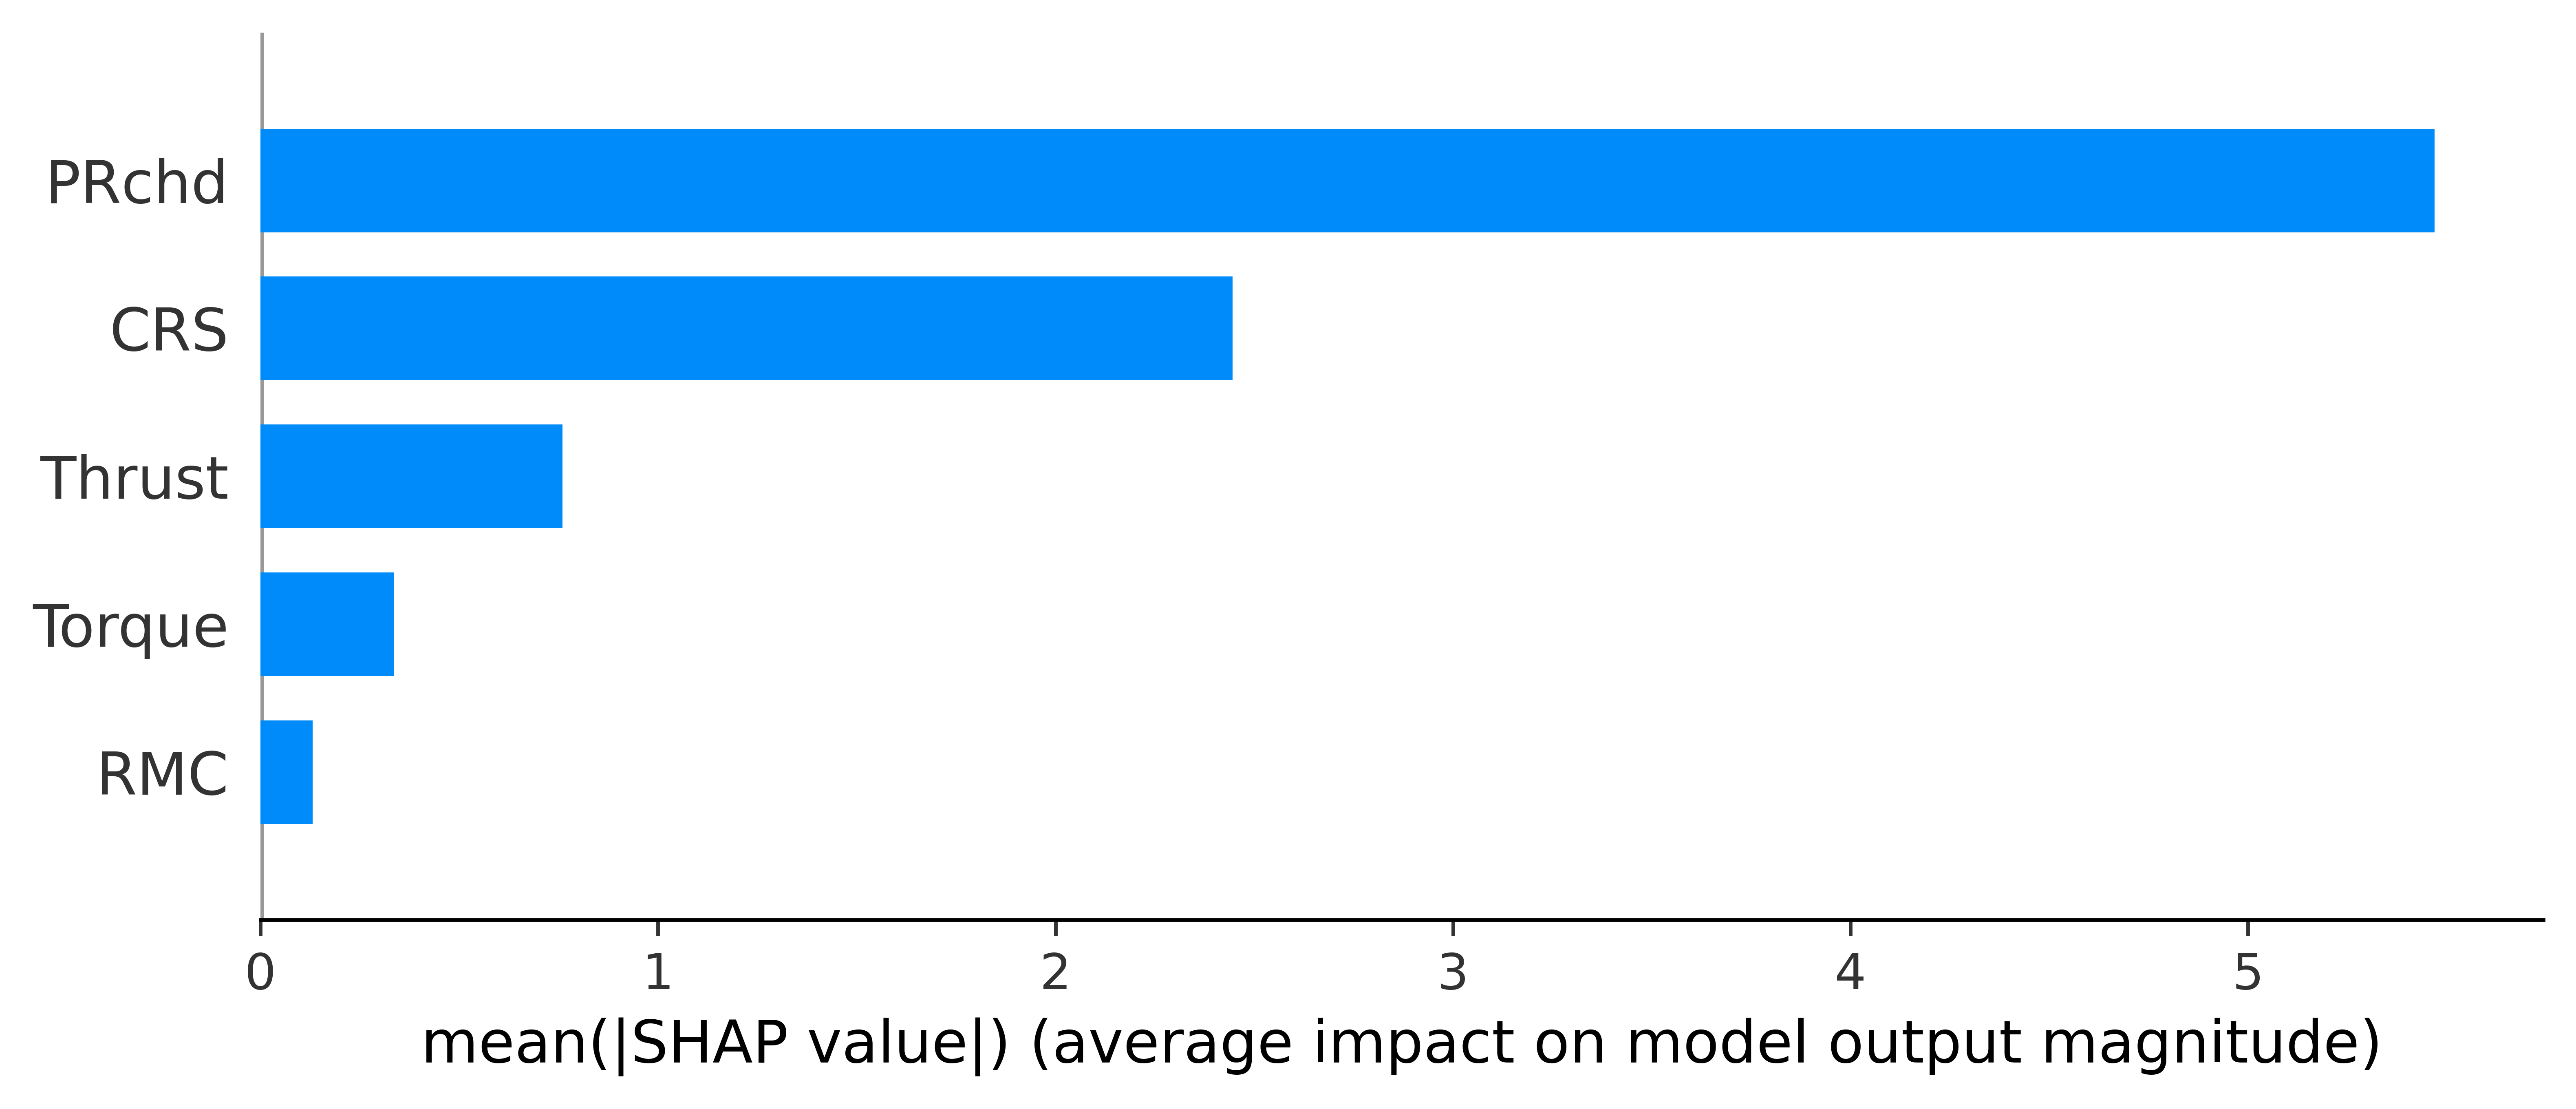

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


SHAP Summary Plot (Beeswarm) - Random Forest (Test Set)


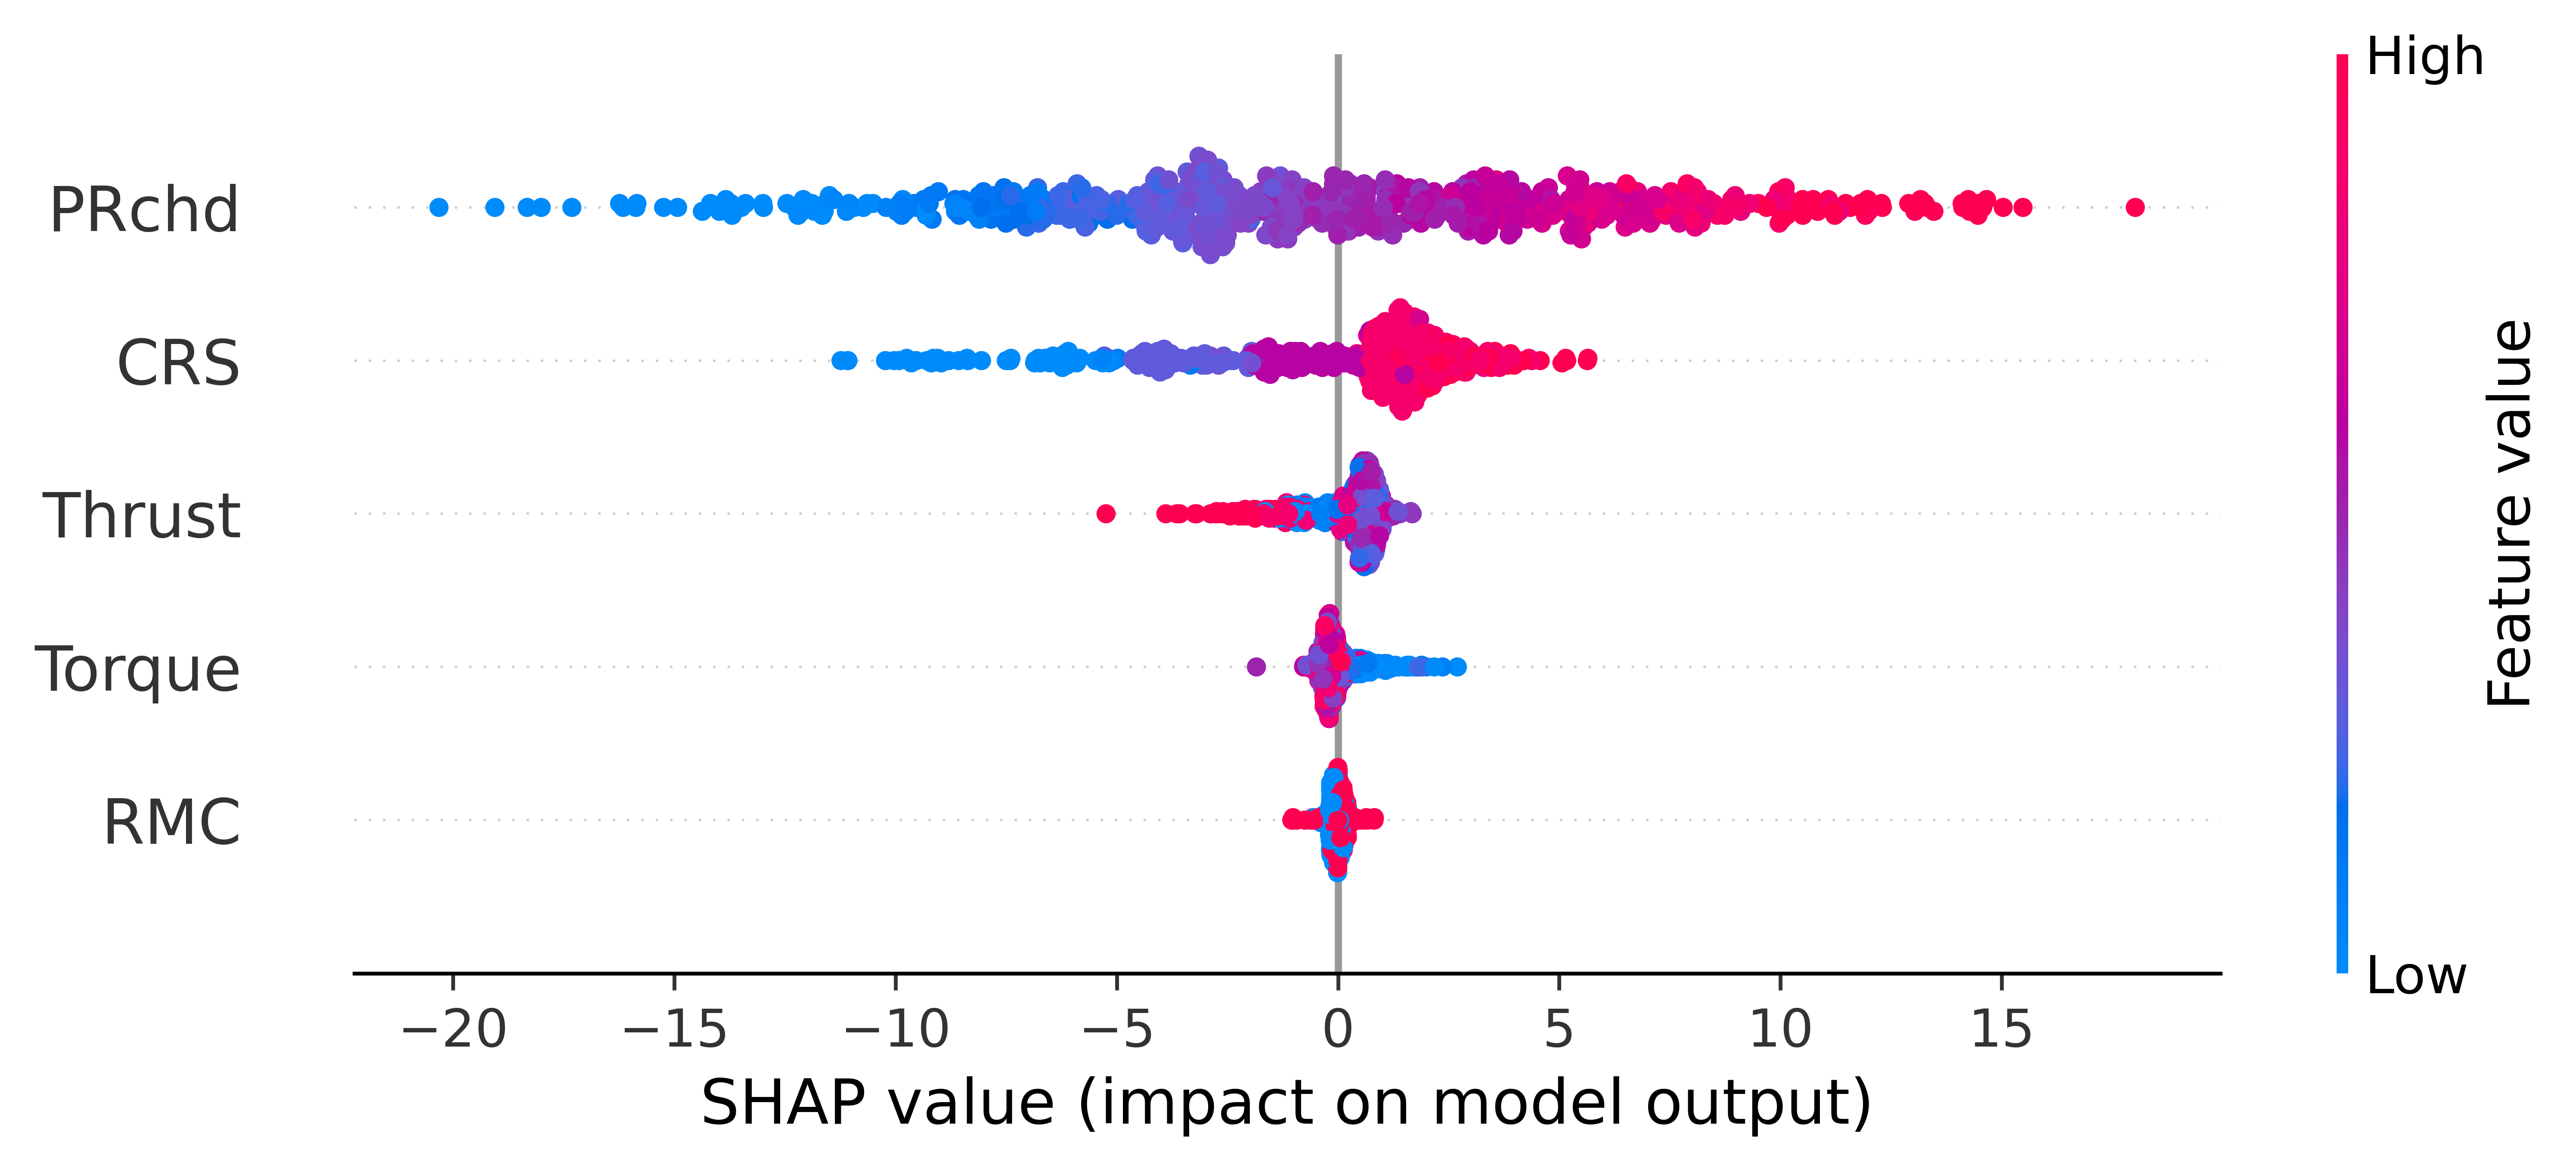

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🔹 SHAP Analysis on Random Forest Model (Test Set Only)
# Select the Random Forest model for SHAP analysis
model_rf = models['Random Forest']

# Create a SHAP explainer object for the Random Forest model
explainer = shap.TreeExplainer(model_rf)

# Calculate SHAP values for the test set only
shap_values = explainer.shap_values(X_test)

# Feature names for better readability in plots
feature_names = ['CRS', 'Torque', 'Thrust', 'PRchd', 'RMC']

# Summary plot (bar plot) for overall feature importance on test set
print("SHAP Summary Plot (Bar) - Random Forest (Test Set)")
plt.figure(dpi=800)  # Set DPI for high resolution
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
plt.savefig('shap_summary_bar_rf_test.png', dpi=800, bbox_inches='tight')
plt.show()
files.download('shap_summary_bar_rf_test.png')  # Download the file

# Detailed summary plot (beeswarm plot) for feature impact on test set
print("\nSHAP Summary Plot (Beeswarm) - Random Forest (Test Set)")
plt.figure(dpi=800)  # Set DPI for high resolution
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.savefig('shap_summary_beeswarm_rf_test.png', dpi=800, bbox_inches='tight')
plt.show()
files.download('shap_summary_beeswarm_rf_test.png')  # Download the file

In [ ]:
# Define features and target
X = data[['CRS', 'Torque', 'Thrust', 'PRchd', 'RMC_RF']]  # Replace with actual feature names
y = data['PRnet']  # Replace with actual target column name

In [ ]:
# Label encoding for categorical columns
label_encoder = LabelEncoder()
X = X.copy()  # Avoid SettingWithCopyWarning
for col in ['RMC_RF']:
    X[col] = label_encoder.fit_transform(X[col])

print(X.head())  # Check preprocessed data

   CRS  Torque  Thrust  PRchd  RMC_RF
0  5.0     415    4118    8.0       1
1  4.5     387    5084    7.3       1
2  5.0     586    7345    7.1       1
3  5.5     407    6004    7.8       1
4  4.5     460    7152    7.9       1


In [ ]:
# Normalize features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# 🔹 Use Best Hyperparameters from GridSearchCV
best_params = {
    "SVM": {'C': 40, 'gamma': 'auto', 'kernel': 'rbf'},
    "Decision Tree": {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10},
    "KNN": {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'},
    "Random Forest": {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
}

# Initialize models with best hyperparameters
models = {
    "SVM": SVR(**best_params["SVM"]),
    "Decision Tree": DecisionTreeRegressor(**best_params["Decision Tree"]),
    "KNN": KNeighborsRegressor(**best_params["KNN"]),
    "Random Forest": RandomForestRegressor(**best_params["Random Forest"])
}

# 🔹 Train and Evaluate Best Models on the Test Set
results = {
    "Model": [], "R²": [], "MAE": [], "MSE": [], "RMSE": [], "RRMSE": [], "MAPE": [], "MRE": [], "VAF": []
}

# Dictionary to store predictions for each model (on the entire dataset)
predictions_dict = {
    "Actual_PRnet": y.values  # Store actual PRnet values for the entire dataset
}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions on the test set for evaluation
    y_pred_test = model.predict(X_test)

    # Compute Metrics (on the test set)
    r2 = r2_score(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    rrmse = rmse / np.mean(y_test) if np.mean(y_test) != 0 else np.nan  # Avoid division by zero
    mape = np.mean(np.abs((y_test - y_pred_test) / (y_test + 1e-10))) * 100  # Add epsilon to avoid division by zero
    mre = np.mean(np.abs(y_test - y_pred_test) / (np.abs(y_test) + np.abs(y_pred_test) + 1e-10)) * 100  # Add epsilon
    vaf = (1 - np.var(y_test - y_pred_test) / np.var(y_test)) * 100  # Variance Accounted For

    # Store Results (for test set evaluation)
    results["Model"].append(name)
    results["R²"].append(round(r2, 3))
    results["MAE"].append(round(mae, 3))
    results["MSE"].append(round(mse, 3))
    results["RMSE"].append(round(rmse, 3))
    results["RRMSE"].append(round(rrmse, 3))
    results["MAPE"].append(round(mape, 3))
    results["MRE"].append(round(mre, 3))
    results["VAF"].append(round(vaf, 3))

    # Predictions on the entire dataset
    y_pred_all = model.predict(X_scaled)

    # Store predictions in the dictionary (for the entire dataset)
    predictions_dict[f"Predicted_PRnet_{name}"] = y_pred_all

# Convert results to a DataFrame and display (test set evaluation)
results_df = pd.DataFrame(results)
display(results_df)

# 🔹 Create a DataFrame with actual and predicted PRnet values (for the entire dataset)
predictions_df = pd.DataFrame(predictions_dict)

# Reset index to align with the entire dataset
predictions_df.index = y.index

# Add the original features for context
# Inverse transform the scaled features to get them back to original scale
X_original = scaler.inverse_transform(X_scaled)
X_df = pd.DataFrame(X_original, columns=X.columns, index=y.index)
predictions_df = pd.concat([X_df, predictions_df], axis=1)

# Display the predictions DataFrame
print("\nPredictions DataFrame (Entire Dataset):")
display(predictions_df.head())

# Save predictions to an Excel file
predictions_file = 'predicted_penetration_rates_RF.xlsx'
predictions_df.to_excel(predictions_file, index=True)

# Download the file
files.download(predictions_file)

,Model,R²,MAE,MSE,RMSE,RRMSE,MAPE,MRE,VAF
0,SVM,0.991,0.537,0.572,0.756,0.014,1.028,0.514,99.064
1,Decision Tree,0.978,0.785,1.359,1.166,0.022,1.508,0.748,97.776
2,KNN,0.961,1.053,2.350,1.533,0.028,2.038,1.005,96.149
3,Random Forest,0.975,0.823,1.502,1.226,0.023,1.612,0.796,97.533



Predictions DataFrame (Entire Dataset):


,CRS,Torque,Thrust,PRchd,RMC_RF,Actual_PRnet,Predicted_PRnet_SVM,Predicted_PRnet_Decision Tree,Predicted_PRnet_KNN,Predicted_PRnet_Random Forest
0,5.0,415.0,4118.0,8.0,1.0,40.0,39.978583,41.233333,42.161315,41.9115
1,4.5,387.0,5084.0,7.3,1.0,32.4,32.500379,35.437500,32.400000,32.4000
2,5.0,586.0,7345.0,7.1,1.0,36.0,34.458197,35.437500,36.000000,36.0000
3,5.5,407.0,6004.0,7.8,1.0,42.8,42.700307,42.350000,42.800000,42.8000
4,4.5,460.0,7152.0,7.9,1.0,36.0,35.900020,36.000000,36.000000,36.0000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Define features and target
X = data[['CRS', 'Torque', 'Thrust', 'PRchd', 'RMC_SVM']]  # Replace with actual feature names
y = data['PRnet']  # Replace with actual target column name

In [ ]:
# Label encoding for categorical columns
label_encoder = LabelEncoder()
X = X.copy()  # Avoid SettingWithCopyWarning
for col in ['RMC_SVM']:
    X[col] = label_encoder.fit_transform(X[col])

print(X.head())  # Check preprocessed data

   CRS  Torque  Thrust  PRchd  RMC_SVM
0  5.0     415    4118    8.0        1
1  4.5     387    5084    7.3        1
2  5.0     586    7345    7.1        1
3  5.5     407    6004    7.8        2
4  4.5     460    7152    7.9        1


In [ ]:
# Normalize features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# 🔹 Use Best Hyperparameters from GridSearchCV
best_params = {
    "SVM": {'C': 40, 'gamma': 'auto', 'kernel': 'rbf'},
    "Decision Tree": {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5},
    "KNN": {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'},
    "Random Forest": {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
}

# Initialize models with best hyperparameters
models = {
    "SVM": SVR(**best_params["SVM"]),
    "Decision Tree": DecisionTreeRegressor(**best_params["Decision Tree"]),
    "KNN": KNeighborsRegressor(**best_params["KNN"]),
    "Random Forest": RandomForestRegressor(**best_params["Random Forest"])
}

# 🔹 Train and Evaluate Best Models on the Test Set
results = {
    "Model": [], "R²": [], "MAE": [], "MSE": [], "RMSE": [], "RRMSE": [], "MAPE": [], "MRE": [], "VAF": []
}

# Dictionary to store predictions for each model (on the entire dataset)
predictions_dict = {
    "Actual_PRnet": y.values  # Store actual PRnet values for the entire dataset
}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions on the test set for evaluation
    y_pred_test = model.predict(X_test)

    # Compute Metrics (on the test set)
    r2 = r2_score(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    rrmse = rmse / np.mean(y_test) if np.mean(y_test) != 0 else np.nan  # Avoid division by zero
    mape = np.mean(np.abs((y_test - y_pred_test) / (y_test + 1e-10))) * 100  # Add epsilon to avoid division by zero
    mre = np.mean(np.abs(y_test - y_pred_test) / (np.abs(y_test) + np.abs(y_pred_test) + 1e-10)) * 100  # Add epsilon
    vaf = (1 - np.var(y_test - y_pred_test) / np.var(y_test)) * 100  # Variance Accounted For

    # Store Results (for test set evaluation)
    results["Model"].append(name)
    results["R²"].append(round(r2, 3))
    results["MAE"].append(round(mae, 3))
    results["MSE"].append(round(mse, 3))
    results["RMSE"].append(round(rmse, 3))
    results["RRMSE"].append(round(rrmse, 3))
    results["MAPE"].append(round(mape, 3))
    results["MRE"].append(round(mre, 3))
    results["VAF"].append(round(vaf, 3))

    # Predictions on the entire dataset
    y_pred_all = model.predict(X_scaled)

    # Store predictions in the dictionary (for the entire dataset)
    predictions_dict[f"Predicted_PRnet_{name}"] = y_pred_all

# Convert results to a DataFrame and display (test set evaluation)
results_df = pd.DataFrame(results)
display(results_df)

# 🔹 Create a DataFrame with actual and predicted PRnet values (for the entire dataset)
predictions_df = pd.DataFrame(predictions_dict)

# Reset index to align with the entire dataset
predictions_df.index = y.index

# Add the original features for context
# Inverse transform the scaled features to get them back to original scale
X_original = scaler.inverse_transform(X_scaled)
X_df = pd.DataFrame(X_original, columns=X.columns, index=y.index)
predictions_df = pd.concat([X_df, predictions_df], axis=1)

# Display the predictions DataFrame
print("\nPredictions DataFrame (Entire Dataset):")
display(predictions_df.head())

# Save predictions to an Excel file
predictions_file = 'predicted_penetration_rates_SVM.xlsx'
predictions_df.to_excel(predictions_file, index=True)

# Download the file
files.download(predictions_file)

,Model,R²,MAE,MSE,RMSE,RRMSE,MAPE,MRE,VAF
0,SVM,0.990,0.543,0.611,0.782,0.014,1.046,0.521,98.996
1,Decision Tree,0.981,0.759,1.148,1.071,0.020,1.451,0.723,98.119
2,KNN,0.967,0.966,2.016,1.420,0.026,1.885,0.929,96.699
3,Random Forest,0.975,0.824,1.520,1.233,0.023,1.618,0.797,97.515



Predictions DataFrame (Entire Dataset):


,CRS,Torque,Thrust,PRchd,RMC_SVM,Actual_PRnet,Predicted_PRnet_SVM,Predicted_PRnet_Decision Tree,Predicted_PRnet_KNN,Predicted_PRnet_Random Forest
0,5.0,415.0,4118.0,8.0,1.0,40.0,39.767330,41.233333,42.161315,41.708
1,4.5,387.0,5084.0,7.3,1.0,32.4,32.499962,33.566667,32.400000,32.400
2,5.0,586.0,7345.0,7.1,1.0,36.0,35.141494,35.833333,36.000000,36.000
3,5.5,407.0,6004.0,7.8,2.0,42.8,42.410635,42.600000,42.800000,42.800
4,4.5,460.0,7152.0,7.9,1.0,36.0,35.899759,36.000000,36.000000,36.000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
##CHECK CHECK

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary Libraries
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, label_binarize
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files

# Load the Excel file from Google Drive
file_path = '/content/drive/My Drive/predictions23march_rmc.xlsx'
data = pd.read_excel(file_path)
print("Original columns:", data.columns)

# Drop the "RMR" column
data = data.drop(columns=['RMR'])
print("Columns after dropping RMR:", data.columns)

# Define features and target
X = data[['CRS', 'Torque', 'PRchd', 'Thrust', 'RMC']]
y = data['PRnet']

# Label encoding for categorical columns
label_encoder = LabelEncoder()
X = X.copy()
for col in ['RMC']:
    X[col] = label_encoder.fit_transform(X[col])

print("Preprocessed X head:\n", X.head())

# Normalize features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🔹 Use Best Hyperparameters (Adjusted to Reduce Overfitting)
best_params = {
    "SVM": {'C': 40, 'gamma': 'auto', 'kernel': 'rbf'},
    "Decision Tree": {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5},
    "KNN": {'algorithm': 'auto', 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'},  # Adjusted
    "Random Forest": {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}  # Adjusted
}

# Initialize models with best hyperparameters
models = {
    "SVM": SVR(**best_params["SVM"]),
    "Decision Tree": DecisionTreeRegressor(**best_params["Decision Tree"]),
    "KNN": KNeighborsRegressor(**best_params["KNN"]),
    "Random Forest": RandomForestRegressor(**best_params["Random Forest"])
}

# 🔹 Cross-Validation Check
print("\nCross-Validated R² Scores:")
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
    print(f"{name}: {np.mean(scores):.3f} (±{np.std(scores):.3f})")

# 🔹 Train and Evaluate Best Models on the Test Set
results = {
    "Model": [],
    "R²": [],
    "Adjusted R²": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "RRMSE": [],
    "MAPE": [],
    "MRE": [],
    "VAF": []
}

# Dictionary to store predictions for each model (on the entire dataset)
predictions_dict = {
    "Actual_PRnet": y.values
}

# Function to calculate Adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else np.nan

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions on the test set for evaluation
    y_pred_test = model.predict(X_test)

    # Compute Metrics (on the test set)
    r2 = r2_score(y_test, y_pred_test)
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2 = adjusted_r2(r2, n, p)

    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    rrmse = rmse / np.mean(y_test) if np.mean(y_test) != 0 else np.nan
    mape = np.mean(np.abs((y_test - y_pred_test) / (y_test + 1e-10))) * 100
    mre = np.mean(np.abs(y_test - y_pred_test) / (np.abs(y_test) + np.abs(y_pred_test) + 1e-10)) * 100
    vaf = (1 - np.var(y_test - y_pred_test) / np.var(y_test)) * 100

    # Store Results (for test set evaluation)
    results["Model"].append(name)
    results["R²"].append(round(r2, 3))
    results["Adjusted R²"].append(round(adj_r2, 3))
    results["MAE"].append(round(mae, 3))
    results["MSE"].append(round(mse, 3))
    results["RMSE"].append(round(rmse, 3))
    results["RRMSE"].append(round(rrmse, 3))
    results["MAPE"].append(round(mape, 3))
    results["MRE"].append(round(mre, 3))
    results["VAF"].append(round(vaf, 3))

    # Predictions on the entire dataset
    y_pred_all = model.predict(X_scaled)

    # Store predictions in the dictionary (for the entire dataset)
    predictions_dict[f"Predicted_PRnet_{name}"] = y_pred_all

# Convert results to a DataFrame and display (test set evaluation)
results_df = pd.DataFrame(results)
print("\nTest Set Evaluation Metrics:")
display(results_df)

# 🔹 Feature Importance for Random Forest
rf = models["Random Forest"]
rf.fit(X_train, y_train)
importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
print("\nRandom Forest Feature Importances:")
print(importances.sort_values('Importance', ascending=False))

# 🔹 Create a DataFrame with actual and predicted PRnet values
predictions_df = pd.DataFrame(predictions_dict)
predictions_df.index = y.index

X_original = scaler.inverse_transform(X_scaled)
X_df = pd.DataFrame(X_original, columns=X.columns, index=y.index)
predictions_df = pd.concat([X_df, predictions_df], axis=1)

print("\nPredictions DataFrame (Entire Dataset):")
display(predictions_df.head())

predictions_file = 'predicted_penetration_rates_actual.xlsx'
predictions_df.to_excel(predictions_file, index=True)
files.download(predictions_file)

# Additional Check: Dataset Size and Correlations
print(f"\nDataset Size: {len(data)} rows")
print("\nFeature-Target Correlations:")
X_with_target = X.copy()
X_with_target['PRnet'] = y
print(X_with_target.corr()['PRnet'].sort_values(ascending=False))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original columns: Index(['Chainage', 'CRS', 'Torque', 'PRchd', 'Thrust', 'PRnet', 'RMR', 'RMC',
       'RMC_RF', 'RMC_SVM', 'SE', 'FPI', 'Lithology', 'Formation',
       'Weathering', 'Strength'],
      dtype='object')
Columns after dropping RMR: Index(['Chainage', 'CRS', 'Torque', 'PRchd', 'Thrust', 'PRnet', 'RMC',
       'RMC_RF', 'RMC_SVM', 'SE', 'FPI', 'Lithology', 'Formation',
       'Weathering', 'Strength'],
      dtype='object')
Preprocessed X head:
    CRS  Torque  PRchd  Thrust  RMC
0  5.0     415    8.0    4118    1
1  4.5     387    7.3    5084    1
2  5.0     586    7.1    7345    1
3  5.5     407    7.8    6004    1
4  4.5     460    7.9    7152    1

Cross-Validated R² Scores:
SVM: 0.959 (±0.038)
Decision Tree: 0.962 (±0.022)
KNN: 0.879 (±0.087)
Random Forest: 0.875 (±0.104)

Test Set Evaluation Metrics:


,Model,R²,Adjusted R²,MAE,MSE,RMSE,RRMSE,MAPE,MRE,VAF
0,SVM,0.990,0.990,0.540,0.595,0.772,0.014,1.037,0.517,99.025
1,Decision Tree,0.980,0.980,0.756,1.227,1.108,0.020,1.453,0.722,97.985
2,KNN,0.955,0.954,1.152,2.747,1.657,0.031,2.233,1.100,95.492
3,Random Forest,0.954,0.953,1.043,2.825,1.681,0.031,2.060,1.008,95.366



Random Forest Feature Importances:
  Feature  Importance
2   PRchd    0.710203
0     CRS    0.124662
3  Thrust    0.113249
1  Torque    0.042199
4     RMC    0.009687

Predictions DataFrame (Entire Dataset):


,CRS,Torque,PRchd,Thrust,RMC,Actual_PRnet,Predicted_PRnet_SVM,Predicted_PRnet_Decision Tree,Predicted_PRnet_KNN,Predicted_PRnet_Random Forest
0,5.0,415.0,8.0,4118.0,1.0,40.0,39.972230,40.100000,41.46,42.206852
1,4.5,387.0,7.3,5084.0,1.0,32.4,32.499511,33.566667,37.20,39.243165
2,5.0,586.0,7.1,7345.0,1.0,36.0,35.485972,35.833333,36.29,38.568657
3,5.5,407.0,7.8,6004.0,1.0,42.8,42.884499,42.600000,47.40,44.544022
4,4.5,460.0,7.9,7152.0,1.0,36.0,35.900001,36.000000,39.87,42.186010


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Dataset Size: 3173 rows

Feature-Target Correlations:
PRnet     1.000000
PRchd     0.800817
RMC       0.146463
CRS       0.034063
Torque   -0.211709
Thrust   -0.285579
Name: PRnet, dtype: float64


In [ ]:
# 🔹 Evaluate Training and Testing Accuracy to Check for Overfitting
train_test_results = {
    "Model": [],
    "Train R²": [],
    "Test R²": [],
    "Train MAE": [],
    "Test MAE": [],
    "Train MSE": [],
    "Test MSE": [],
    "Train RMSE": [],
    "Test RMSE": []
}

for name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)

    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)

    train_test_results["Model"].append(name)
    train_test_results["Train R²"].append(round(train_r2, 3))
    train_test_results["Test R²"].append(round(test_r2, 3))
    train_test_results["Train MAE"].append(round(train_mae, 3))
    train_test_results["Test MAE"].append(round(test_mae, 3))
    train_test_results["Train MSE"].append(round(train_mse, 3))
    train_test_results["Test MSE"].append(round(test_mse, 3))
    train_test_results["Train RMSE"].append(round(train_rmse, 3))
    train_test_results["Test RMSE"].append(round(test_rmse, 3))

train_test_df = pd.DataFrame(train_test_results)
print("\nTraining vs. Testing Metrics (to Check for Overfitting):")
display(train_test_df)

print("\nOverfitting Analysis:")
for index, row in train_test_df.iterrows():
    r2_diff = row["Train R²"] - row["Test R²"]
    print(f"{row['Model']}:")
    print(f"  R² Difference (Train - Test): {r2_diff:.3f}")
    if r2_diff > 0.1:
        print("  - Potential overfitting: Training R² is significantly higher than Test R².")
    elif r2_diff > 0.05:
        print("  - Mild overfitting: Training R² is slightly higher than Test R².")
    else:
        print("  - No significant overfitting: Training and Test R² are close.")
    print(f"  RMSE Difference (Test - Train): {row['Test RMSE'] - row['Train RMSE']:.3f}")
    print()


Training vs. Testing Metrics (to Check for Overfitting):


,Model,Train R²,Test R²,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE
0,SVM,0.993,0.990,0.491,0.540,0.469,0.595,0.685,0.772
1,Decision Tree,0.995,0.980,0.441,0.756,0.351,1.227,0.592,1.108
2,KNN,0.960,0.955,1.096,1.152,2.722,2.747,1.650,1.657
3,Random Forest,0.968,0.952,0.881,1.058,2.169,2.896,1.473,1.702



Overfitting Analysis:
SVM:
  R² Difference (Train - Test): 0.003
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.087

Decision Tree:
  R² Difference (Train - Test): 0.015
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.516

KNN:
  R² Difference (Train - Test): 0.005
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.007

Random Forest:
  R² Difference (Train - Test): 0.016
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.229



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary Libraries
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, label_binarize
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files
import joblib

# Load the Excel file from Google Drive
file_path = '/content/drive/My Drive/predictions23march_rmc.xlsx'
data = pd.read_excel(file_path)
print("Original columns:", data.columns)

# Drop the "RMR" column
data = data.drop(columns=['RMR'])
print("Columns after dropping RMR:", data.columns)

# Define features and target
X = data[['CRS', 'Torque', 'PRchd', 'Thrust', 'RMC']]
y = data['PRnet']

# Label encoding for categorical columns
label_encoder = LabelEncoder()
X = X.copy()
for col in ['RMC']:
    X[col] = label_encoder.fit_transform(X[col])

print("Preprocessed X head:\n", X.head())

# Normalize features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🔹 Use Best Hyperparameters
best_params = {
    "SVM": {'C': 40, 'gamma': 'auto', 'kernel': 'rbf'},
    "Decision Tree": {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5},
    "KNN": {'algorithm': 'auto', 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'},
    "Random Forest": {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
}

# Initialize models with best hyperparameters
models = {
    "SVM": SVR(**best_params["SVM"]),
    "Decision Tree": DecisionTreeRegressor(**best_params["Decision Tree"]),
    "KNN": KNeighborsRegressor(**best_params["KNN"]),
    "Random Forest": RandomForestRegressor(**best_params["Random Forest"])
}

# 🔹 Cross-Validation Check
print("\nCross-Validated R² Scores:")
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=10, scoring='r2')
    print(f"{name}: {np.mean(scores):.3f} (±{np.std(scores):.3f})")

# 🔹 Train and Evaluate Best Models on the Test Set
results = {
    "Model": [],
    "R²": [],
    "Adjusted R²": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "RRMSE": [],
    "MAPE": [],
    "MRE": [],
    "VAF": []
}

# Dictionary to store predictions for each model (on the entire dataset)
predictions_dict = {
    "Actual_PRnet": y.values
}

# Function to calculate Adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else np.nan

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions on the test set for evaluation
    y_pred_test = model.predict(X_test)

    # Compute Metrics (on the test set)
    r2 = r2_score(y_test, y_pred_test)
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2 = adjusted_r2(r2, n, p)

    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    rrmse = rmse / np.mean(y_test) if np.mean(y_test) != 0 else np.nan
    mape = np.mean(np.abs((y_test - y_pred_test) / (y_test + 1e-10))) * 100
    mre = np.mean(np.abs(y_test - y_pred_test) / (np.abs(y_test) + np.abs(y_pred_test) + 1e-10)) * 100
    vaf = (1 - np.var(y_test - y_pred_test) / np.var(y_test)) * 100

    # Store Results (for test set evaluation)
    results["Model"].append(name)
    results["R²"].append(round(r2, 3))
    results["Adjusted R²"].append(round(adj_r2, 3))
    results["MAE"].append(round(mae, 3))
    results["MSE"].append(round(mse, 3))
    results["RMSE"].append(round(rmse, 3))
    results["RRMSE"].append(round(rrmse, 3))
    results["MAPE"].append(round(mape, 3))
    results["MRE"].append(round(mre, 3))
    results["VAF"].append(round(vaf, 3))

    # Predictions on the entire dataset
    y_pred_all = model.predict(X_scaled)

    # Store predictions in the dictionary (for the entire dataset)
    predictions_dict[f"Predicted_PRnet_{name}"] = y_pred_all

# Convert results to a DataFrame and display (test set evaluation)
results_df = pd.DataFrame(results)
print("\nTest Set Evaluation Metrics:")
display(results_df)

# 🔹 Feature Importance for Random Forest
rf = models["Random Forest"]
rf.fit(X_train, y_train)
importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
print("\nRandom Forest Feature Importances:")
print(importances.sort_values('Importance', ascending=False))

# 🔹 Create a DataFrame with actual and predicted PRnet values
predictions_df = pd.DataFrame(predictions_dict)
predictions_df.index = y.index

X_original = scaler.inverse_transform(X_scaled)
X_df = pd.DataFrame(X_original, columns=X.columns, index=y.index)
predictions_df = pd.concat([X_df, predictions_df], axis=1)

print("\nPredictions DataFrame (Entire Dataset):")
display(predictions_df.head())

# 🔹 Save the best model (SVM) and scaler for deployment
best_model = models["SVM"]
joblib.dump(best_model, 'best_model_svm.pkl')
joblib.dump(scaler, 'scaler.pkl')
files.download('best_model_svm.pkl')
files.download('scaler.pkl')

predictions_file = 'predicted_penetration_rates_actual.xlsx'
predictions_df.to_excel(predictions_file, index=True)
files.download(predictions_file)

# Additional Check: Dataset Size and Correlations
print(f"\nDataset Size: {len(data)} rows")
print("\nFeature-Target Correlations:")
X_with_target = X.copy()
X_with_target['PRnet'] = y
print(X_with_target.corr()['PRnet'].sort_values(ascending=False))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original columns: Index(['Chainage', 'CRS', 'Torque', 'PRchd', 'Thrust', 'PRnet', 'RMR', 'RMC',
       'RMC_RF', 'RMC_SVM', 'SE', 'FPI', 'Lithology', 'Formation',
       'Weathering', 'Strength'],
      dtype='object')
Columns after dropping RMR: Index(['Chainage', 'CRS', 'Torque', 'PRchd', 'Thrust', 'PRnet', 'RMC',
       'RMC_RF', 'RMC_SVM', 'SE', 'FPI', 'Lithology', 'Formation',
       'Weathering', 'Strength'],
      dtype='object')
Preprocessed X head:
    CRS  Torque  PRchd  Thrust  RMC
0  5.0     415    8.0    4118    1
1  4.5     387    7.3    5084    1
2  5.0     586    7.1    7345    1
3  5.5     407    7.8    6004    1
4  4.5     460    7.9    7152    1

Cross-Validated R² Scores:
SVM: 0.965 (±0.046)
Decision Tree: 0.964 (±0.033)
KNN: 0.899 (±0.065)
Random Forest: 0.898 (±0.082)

Test Set Evaluation Metrics:


,Model,R²,Adjusted R²,MAE,MSE,RMSE,RRMSE,MAPE,MRE,VAF
0,SVM,0.990,0.990,0.540,0.595,0.772,0.014,1.037,0.517,99.025
1,Decision Tree,0.980,0.980,0.759,1.236,1.112,0.021,1.458,0.725,97.971
2,KNN,0.955,0.954,1.152,2.747,1.657,0.031,2.233,1.100,95.492
3,Random Forest,0.954,0.953,1.062,2.827,1.681,0.031,2.091,1.024,95.364



Random Forest Feature Importances:
  Feature  Importance
2   PRchd    0.703268
0     CRS    0.122883
3  Thrust    0.119539
1  Torque    0.045269
4     RMC    0.009041

Predictions DataFrame (Entire Dataset):


,CRS,Torque,PRchd,Thrust,RMC,Actual_PRnet,Predicted_PRnet_SVM,Predicted_PRnet_Decision Tree,Predicted_PRnet_KNN,Predicted_PRnet_Random Forest
0,5.0,415.0,8.0,4118.0,1.0,40.0,39.972230,40.100000,41.46,42.788680
1,4.5,387.0,7.3,5084.0,1.0,32.4,32.499511,33.566667,37.20,39.009868
2,5.0,586.0,7.1,7345.0,1.0,36.0,35.485972,35.833333,36.29,38.974191
3,5.5,407.0,7.8,6004.0,1.0,42.8,42.884499,43.000000,47.40,44.848847
4,4.5,460.0,7.9,7152.0,1.0,36.0,35.900001,36.000000,39.87,43.537158


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Dataset Size: 3173 rows

Feature-Target Correlations:
PRnet     1.000000
PRchd     0.800817
RMC       0.146463
CRS       0.034063
Torque   -0.211709
Thrust   -0.285579
Name: PRnet, dtype: float64


In [ ]:
# 🔹 Evaluate Training and Testing Accuracy to Check for Overfitting
train_test_results = {
    "Model": [],
    "Train R²": [],
    "Test R²": [],
    "Train MAE": [],
    "Test MAE": [],
    "Train MSE": [],
    "Test MSE": [],
    "Train RMSE": [],
    "Test RMSE": []
}

for name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)

    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)

    train_test_results["Model"].append(name)
    train_test_results["Train R²"].append(round(train_r2, 3))
    train_test_results["Test R²"].append(round(test_r2, 3))
    train_test_results["Train MAE"].append(round(train_mae, 3))
    train_test_results["Test MAE"].append(round(test_mae, 3))
    train_test_results["Train MSE"].append(round(train_mse, 3))
    train_test_results["Test MSE"].append(round(test_mse, 3))
    train_test_results["Train RMSE"].append(round(train_rmse, 3))
    train_test_results["Test RMSE"].append(round(test_rmse, 3))

train_test_df = pd.DataFrame(train_test_results)
print("\nTraining vs. Testing Metrics (to Check for Overfitting):")
display(train_test_df)

print("\nOverfitting Analysis:")
for index, row in train_test_df.iterrows():
    r2_diff = row["Train R²"] - row["Test R²"]
    print(f"{row['Model']}:")
    print(f"  R² Difference (Train - Test): {r2_diff:.3f}")
    if r2_diff > 0.1:
        print("  - Potential overfitting: Training R² is significantly higher than Test R².")
    elif r2_diff > 0.05:
        print("  - Mild overfitting: Training R² is slightly higher than Test R².")
    else:
        print("  - No significant overfitting: Training and Test R² are close.")
    print(f"  RMSE Difference (Test - Train): {row['Test RMSE'] - row['Train RMSE']:.3f}")
    print()


Training vs. Testing Metrics (to Check for Overfitting):


,Model,Train R²,Test R²,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE
0,SVM,0.993,0.990,0.491,0.540,0.469,0.595,0.685,0.772
1,Decision Tree,0.995,0.981,0.441,0.754,0.351,1.130,0.592,1.063
2,KNN,0.960,0.955,1.096,1.152,2.722,2.747,1.650,1.657
3,Random Forest,0.967,0.952,0.888,1.058,2.198,2.898,1.483,1.702



Overfitting Analysis:
SVM:
  R² Difference (Train - Test): 0.003
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.087

Decision Tree:
  R² Difference (Train - Test): 0.014
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.471

KNN:
  R² Difference (Train - Test): 0.005
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.007

Random Forest:
  R² Difference (Train - Test): 0.015
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.219



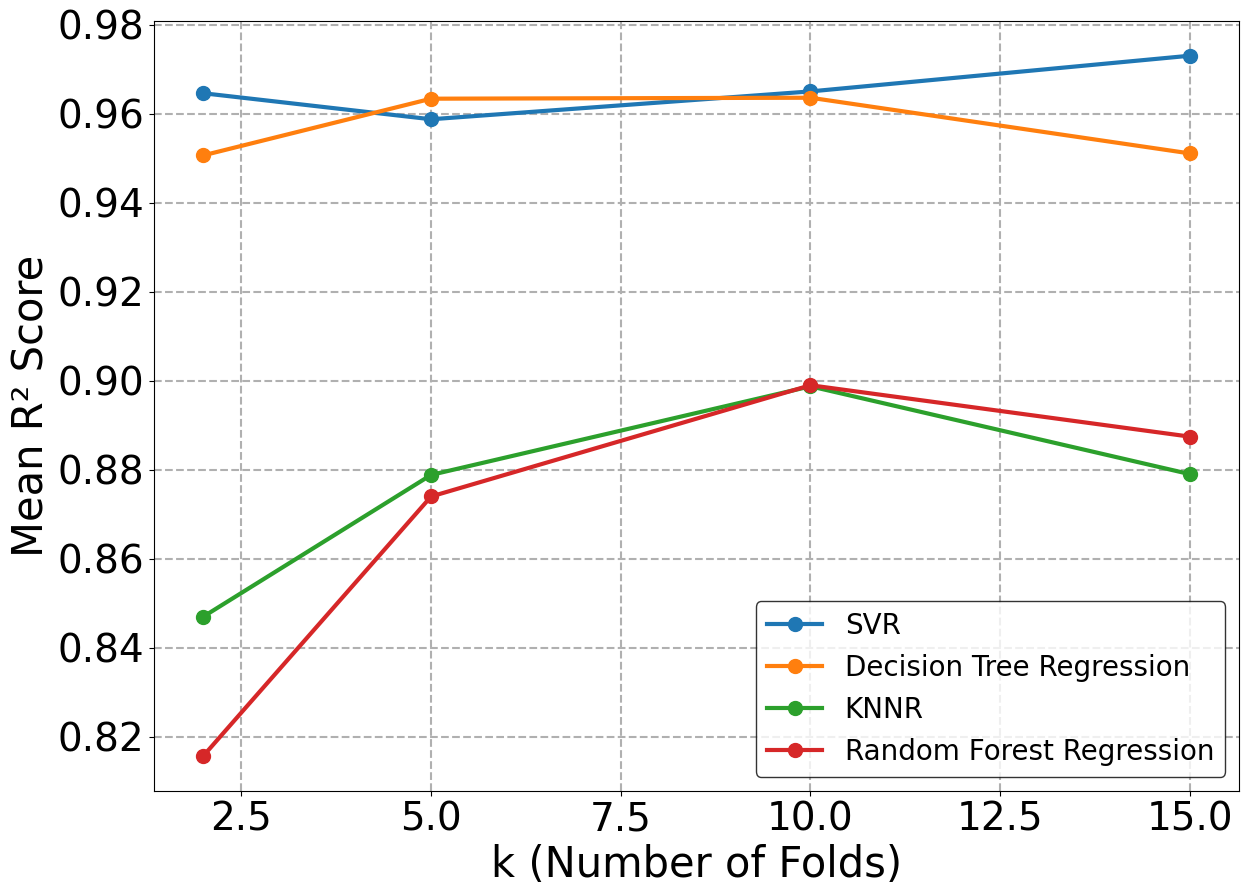

In [ ]:
# Define k values for cross-validation
k_values_cv = [2, 5, 10, 15]  # Integer values for cross-validation

# Initialize a dictionary to store mean R² scores for each model
mean_r2_scores = {name: [] for name in models.keys()}

# Perform cross-validation for different k values
for name, model in models.items():
    for k in k_values_cv:
        scores = cross_val_score(model, X_scaled, y, cv=k, scoring='r2')
        mean_r2_scores[name].append(np.mean(scores))  # Store computed mean R² score

# Define x-ticks for visualization (adding 2.5 for fractional spacing)
k_values_plot = [2.5, 5, 7.5, 10, 12.5, 15]

# Create a mapping for regression-specific names
regression_names = {
    'SVM': 'SVR',
    'Decision Tree': 'Decision Tree Regression',
    'KNN': 'KNNR',
    'Random Forest': 'Random Forest Regression'
}

# Create the plot
plt.figure(figsize=(14, 10), dpi=100)

# Plot dynamically computed mean R² scores with updated labels
for name in models.keys():
    plt.plot(k_values_cv, mean_r2_scores[name], marker='o', markersize=10, linewidth=3,
             label=regression_names[name])

# Customize x-ticks, labels, and grid
plt.xticks(k_values_plot, fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('k (Number of Folds)', fontsize=30)
plt.ylabel('Mean R² Score', fontsize=30)
plt.grid(True, linestyle='--', linewidth=1.5)

# Add legend with correct font size and box format
plt.legend(
    loc="best",
    fontsize=20,
    frameon=True,  # Box around legend
    edgecolor="black",
    fancybox=True  # Rounded box
)

# Save and show the plot
plt.savefig("mean_r2_vs_folds.png", dpi=800, bbox_inches='tight')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original columns: Index(['Chainage', 'CRS', 'Torque', 'PRchd', 'Thrust', 'PRnet', 'RMR', 'RMC',
       'RMC_RF', 'RMC_SVM', 'SE', 'FPI', 'Lithology', 'Formation',
       'Weathering', 'Strength'],
      dtype='object')
Columns after dropping RMR: Index(['Chainage', 'CRS', 'Torque', 'PRchd', 'Thrust', 'PRnet', 'RMC',
       'RMC_RF', 'RMC_SVM', 'SE', 'FPI', 'Lithology', 'Formation',
       'Weathering', 'Strength'],
      dtype='object')
Preprocessed X head:
    CRS  Torque  PRchd  Thrust  RMC
0  5.0     415    8.0    4118    1
1  4.5     387    7.3    5084    1
2  5.0     586    7.1    7345    1
3  5.5     407    7.8    6004    1
4  4.5     460    7.9    7152    1

Cross-Validated R² Scores (10-fold CV):
SVM: 0.965 (±0.046)
Decision Tree: 0.965 (±0.033)
KNN: 0.899 (±0.065)
Random Forest: 0.897 (±0.083)

Test Set Evaluation Metrics:


,Model,R²,Adjusted R²,MAE,MSE,RMSE,RRMSE,MAPE,MRE,VAF
0,SVM,0.990,0.990,0.540,0.595,0.772,0.014,1.037,0.517,99.025
1,Decision Tree,0.980,0.979,0.764,1.244,1.115,0.021,1.472,0.731,97.960
2,KNN,0.955,0.954,1.152,2.747,1.657,0.031,2.233,1.100,95.492
3,Random Forest,0.951,0.951,1.059,2.963,1.721,0.032,2.094,1.023,95.149



Training vs. Testing Metrics (to Check for Overfitting):


,Model,Train R²,Test R²,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE
0,SVM,0.993,0.990,0.491,0.540,0.469,0.595,0.685,0.772
1,Decision Tree,0.995,0.980,0.441,0.764,0.351,1.244,0.592,1.115
2,KNN,0.960,0.955,1.096,1.152,2.722,2.747,1.650,1.657
3,Random Forest,0.968,0.951,0.887,1.059,2.195,2.963,1.482,1.721



Overfitting Analysis:
SVM:
  R² Difference (Train - Test): 0.003
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.087

Decision Tree:
  R² Difference (Train - Test): 0.015
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.523

KNN:
  R² Difference (Train - Test): 0.005
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.007

Random Forest:
  R² Difference (Train - Test): 0.017
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.239


Random Forest Feature Importances:
  Feature  Importance
2   PRchd    0.711050
0     CRS    0.125281
3  Thrust    0.114135
1  Torque    0.040190
4     RMC    0.009345


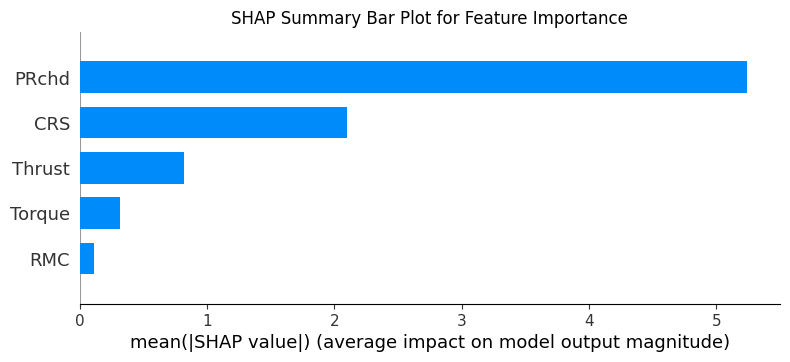

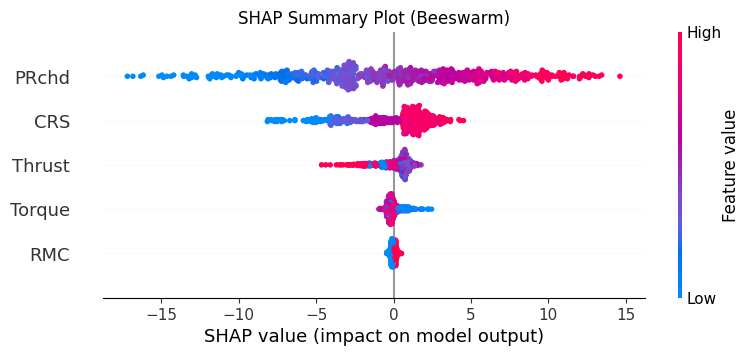


Predictions DataFrame (Entire Dataset):


,CRS,Torque,PRchd,Thrust,RMC,Actual_PRnet,Predicted_PRnet_SVM,Predicted_PRnet_Decision Tree,Predicted_PRnet_KNN,Predicted_PRnet_Random Forest
0,5.0,415.0,8.0,4118.0,1.0,40.0,39.972230,41.233333,41.46,43.161554
1,4.5,387.0,7.3,5084.0,1.0,32.4,32.499511,33.566667,37.20,39.979321
2,5.0,586.0,7.1,7345.0,1.0,36.0,35.485972,35.833333,36.29,39.481531
3,5.5,407.0,7.8,6004.0,1.0,42.8,42.884499,42.600000,47.40,44.569325
4,4.5,460.0,7.9,7152.0,1.0,36.0,35.900001,36.000000,39.87,43.305979


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Dataset Size: 3173 rows

Feature-Target Correlations:
PRnet     1.000000
PRchd     0.800817
RMC       0.146463
CRS       0.034063
Torque   -0.211709
Thrust   -0.285579
Name: PRnet, dtype: float64


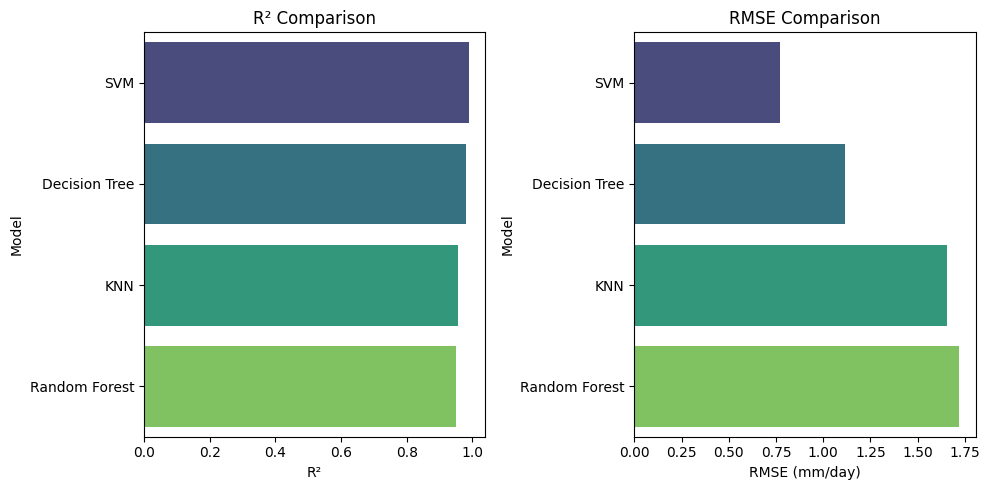

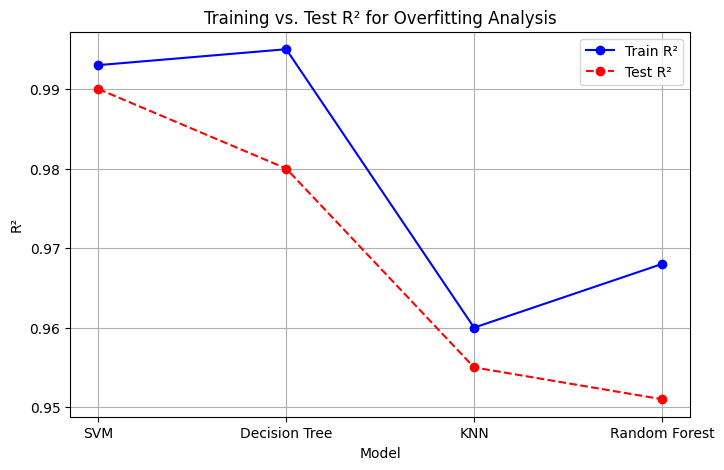

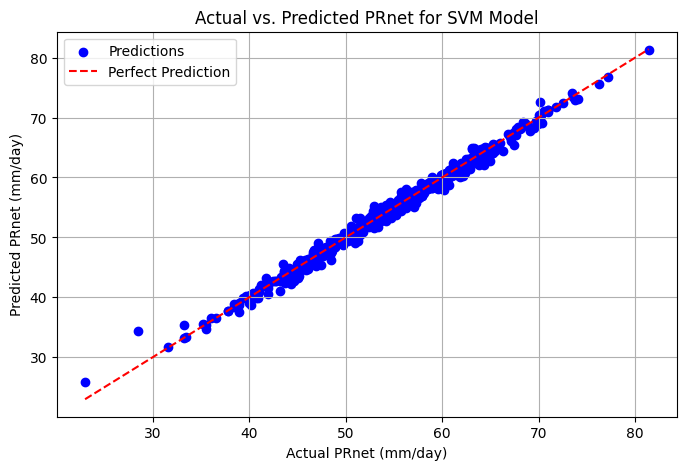

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary Libraries
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, label_binarize
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files
import joblib

# Load the Excel file from Google Drive
file_path = '/content/drive/My Drive/predictions23march_rmc.xlsx'
data = pd.read_excel(file_path)
print("Original columns:", data.columns)

# Drop the "RMR" column
data = data.drop(columns=['RMR'])
print("Columns after dropping RMR:", data.columns)

# Define features and target
X = data[['CRS', 'Torque', 'PRchd', 'Thrust', 'RMC']]
y = data['PRnet']

# Label encoding for categorical columns
label_encoder = LabelEncoder()
X = X.copy()
for col in ['RMC']:
    X[col] = label_encoder.fit_transform(X[col])
print("Preprocessed X head:\n", X.head())

# Save the label encoder for deployment
joblib.dump(label_encoder, 'label_encoder.pkl')

# Normalize features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🔹 Use Best Hyperparameters
best_params = {
    "SVM": {'C': 40, 'gamma': 'auto', 'kernel': 'rbf'},
    "Decision Tree": {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5},
    "KNN": {'algorithm': 'auto', 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'},
    "Random Forest": {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
}

# Initialize models with best hyperparameters
models = {
    "SVM": SVR(**best_params["SVM"]),
    "Decision Tree": DecisionTreeRegressor(**best_params["Decision Tree"]),
    "KNN": KNeighborsRegressor(**best_params["KNN"]),
    "Random Forest": RandomForestRegressor(**best_params["Random Forest"])
}

# 🔹 Cross-Validation Check (10-fold CV)
print("\nCross-Validated R² Scores (10-fold CV):")
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=10, scoring='r2')
    print(f"{name}: {np.mean(scores):.3f} (±{np.std(scores):.3f})")

# 🔹 Train and Evaluate Best Models on the Test Set
results = {
    "Model": [],
    "R²": [],
    "Adjusted R²": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "RRMSE": [],
    "MAPE": [],
    "MRE": [],
    "VAF": []
}

# Dictionary to store predictions for each model (on the entire dataset)
predictions_dict = {
    "Actual_PRnet": y.values
}

# Function to calculate Adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else np.nan

# Store predictions for scatter plot (actual vs. predicted)
svm_predictions = None

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions on the test set for evaluation
    y_pred_test = model.predict(X_test)

    # Compute Metrics (on the test set)
    r2 = r2_score(y_test, y_pred_test)
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2 = adjusted_r2(r2, n, p)

    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    rrmse = rmse / np.mean(y_test) if np.mean(y_test) != 0 else np.nan
    mape = np.mean(np.abs((y_test - y_pred_test) / (y_test + 1e-10))) * 100
    mre = np.mean(np.abs(y_test - y_pred_test) / (np.abs(y_test) + np.abs(y_pred_test) + 1e-10)) * 100
    vaf = (1 - np.var(y_test - y_pred_test) / np.var(y_test)) * 100

    # Store Results (for test set evaluation)
    results["Model"].append(name)
    results["R²"].append(round(r2, 3))
    results["Adjusted R²"].append(round(adj_r2, 3))
    results["MAE"].append(round(mae, 3))
    results["MSE"].append(round(mse, 3))
    results["RMSE"].append(round(rmse, 3))
    results["RRMSE"].append(round(rrmse, 3))
    results["MAPE"].append(round(mape, 3))
    results["MRE"].append(round(mre, 3))
    results["VAF"].append(round(vaf, 3))

    # Predictions on the entire dataset
    y_pred_all = model.predict(X_scaled)

    # Store predictions in the dictionary (for the entire dataset)
    predictions_dict[f"Predicted_PRnet_{name}"] = y_pred_all

    # Store SVM predictions for scatter plot
    if name == "SVM":
        svm_predictions = y_pred_test

# Convert results to a DataFrame and display (test set evaluation)
results_df = pd.DataFrame(results)
print("\nTest Set Evaluation Metrics:")
display(results_df)

# 🔹 Evaluate Training and Testing Accuracy to Check for Overfitting
train_test_results = {
    "Model": [],
    "Train R²": [],
    "Test R²": [],
    "Train MAE": [],
    "Test MAE": [],
    "Train MSE": [],
    "Test MSE": [],
    "Train RMSE": [],
    "Test RMSE": []
}

for name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)

    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)

    train_test_results["Model"].append(name)
    train_test_results["Train R²"].append(round(train_r2, 3))
    train_test_results["Test R²"].append(round(test_r2, 3))
    train_test_results["Train MAE"].append(round(train_mae, 3))
    train_test_results["Test MAE"].append(round(test_mae, 3))
    train_test_results["Train MSE"].append(round(train_mse, 3))
    train_test_results["Test MSE"].append(round(test_mse, 3))
    train_test_results["Train RMSE"].append(round(train_rmse, 3))
    train_test_results["Test RMSE"].append(round(test_rmse, 3))

train_test_df = pd.DataFrame(train_test_results)
print("\nTraining vs. Testing Metrics (to Check for Overfitting):")
display(train_test_df)

print("\nOverfitting Analysis:")
for index, row in train_test_df.iterrows():
    r2_diff = row["Train R²"] - row["Test R²"]
    print(f"{row['Model']}:")
    print(f"  R² Difference (Train - Test): {r2_diff:.3f}")
    if r2_diff > 0.1:
        print("  - Potential overfitting: Training R² is significantly higher than Test R².")
    elif r2_diff > 0.05:
        print("  - Mild overfitting: Training R² is slightly higher than Test R².")
    else:
        print("  - No significant overfitting: Training and Test R² are close.")
    print(f"  RMSE Difference (Test - Train): {row['Test RMSE'] - row['Train RMSE']:.3f}")
    print()

# 🔹 Feature Importance for Random Forest
rf = models["Random Forest"]
rf.fit(X_train, y_train)
importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
print("\nRandom Forest Feature Importances:")
print(importances.sort_values('Importance', ascending=False))

# 🔹 SHAP Analysis for Random Forest
explainer = shap.TreeExplainer(models["Random Forest"])
shap_values = explainer.shap_values(X_test)

# SHAP Summary Bar Plot (Figure 7-5)
plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Summary Bar Plot for Feature Importance")
plt.savefig('figure_7_5_shap_bar.png')
plt.show()

# SHAP Summary Plot (Beeswarm Plot, Figure 7-6)
plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot (Beeswarm)")
plt.savefig('figure_7_6_shap_beeswarm.png')
plt.show()

# 🔹 Create a DataFrame with actual and predicted PRnet values
predictions_df = pd.DataFrame(predictions_dict)
predictions_df.index = y.index

X_original = scaler.inverse_transform(X_scaled)
X_df = pd.DataFrame(X_original, columns=X.columns, index=y.index)
predictions_df = pd.concat([X_df, predictions_df], axis=1)

print("\nPredictions DataFrame (Entire Dataset):")
display(predictions_df.head())

# 🔹 Save the best model (SVM), scaler, and label encoder for deployment
best_model = models["SVM"]
joblib.dump(best_model, 'best_model_svm.pkl')
joblib.dump(scaler, 'scaler.pkl')
files.download('best_model_svm.pkl')
files.download('scaler.pkl')
files.download('label_encoder.pkl')

predictions_file = 'predicted_penetration_rates_actual.xlsx'
predictions_df.to_excel(predictions_file, index=True)
files.download(predictions_file)

# Additional Check: Dataset Size and Correlations
print(f"\nDataset Size: {len(data)} rows")
print("\nFeature-Target Correlations:")
X_with_target = X.copy()
X_with_target['PRnet'] = y
print(X_with_target.corr()['PRnet'].sort_values(ascending=False))

# 🔹 Visualizations for Report

# Figure 7-3: Comparison of R² and RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='R²', y='Model', hue='Model', data=results_df, palette='viridis', legend=False)
plt.title('R² Comparison')
plt.xlabel('R²')
plt.ylabel('Model')

plt.subplot(1, 2, 2)
sns.barplot(x='RMSE', y='Model', hue='Model', data=results_df, palette='viridis', legend=False)
plt.title('RMSE Comparison')
plt.xlabel('RMSE (mm/day)')
plt.ylabel('Model')

plt.tight_layout()
plt.savefig('figure_7_3_comparison.png')
plt.show()

# Figure 7-4: Training vs. Test R²
plt.figure(figsize=(8, 5))
plt.plot(train_test_df['Model'], train_test_df['Train R²'], marker='o', label='Train R²', color='blue')
plt.plot(train_test_df['Model'], train_test_df['Test R²'], marker='o', label='Test R²', color='red', linestyle='--')
plt.title('Training vs. Test R² for Overfitting Analysis')
plt.xlabel('Model')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.savefig('figure_7_4_overfitting.png')
plt.show()

# Figure 7-7: Actual vs. Predicted PRnet for SVM
plt.figure(figsize=(8, 5))
plt.scatter(y_test, svm_predictions, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs. Predicted PRnet for SVM Model')
plt.xlabel('Actual PRnet (mm/day)')
plt.ylabel('Predicted PRnet (mm/day)')
plt.legend()
plt.grid(True)
plt.savefig('figure_7_7_actual_vs_predicted.png')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original columns: Index(['Chainage', 'CRS', 'Torque', 'PRchd', 'Thrust', 'PRnet', 'RMR', 'RMC',
       'RMC_RF', 'RMC_SVM', 'SE', 'FPI', 'Lithology', 'Formation',
       'Weathering', 'Strength'],
      dtype='object')
Columns after dropping RMR: Index(['Chainage', 'CRS', 'Torque', 'PRchd', 'Thrust', 'PRnet', 'RMC',
       'RMC_RF', 'RMC_SVM', 'SE', 'FPI', 'Lithology', 'Formation',
       'Weathering', 'Strength'],
      dtype='object')
Preprocessed X head:
    CRS  Torque  PRchd  Thrust  RMC
0  5.0     415    8.0    4118    1
1  4.5     387    7.3    5084    1
2  5.0     586    7.1    7345    1
3  5.5     407    7.8    6004    1
4  4.5     460    7.9    7152    1

Cross-Validated R² Scores (10-fold CV):
SVR: 0.965 (±0.046)
Decision Tree: 0.964 (±0.033)
KNN: 0.899 (±0.065)
Random Forest: 0.895 (±0.091)

Test Set Evaluation Metrics:


,Model,R²,Adjusted R²,MAE,MSE,RMSE,RRMSE,MAPE,MRE,VAF
0,SVR,0.990,0.990,0.540,0.595,0.772,0.014,1.037,0.517,99.025
1,DTR,0.980,0.980,0.753,1.206,1.098,0.020,1.449,0.720,98.021
2,KNNR,0.955,0.954,1.152,2.747,1.657,0.031,2.233,1.100,95.492
3,RFR,0.954,0.954,1.028,2.774,1.666,0.031,2.034,0.995,95.453



Training vs. Testing Metrics (to Check for Overfitting):


,Model,Train R²,Test R²,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE
0,SVR,0.993,0.990,0.491,0.540,0.469,0.595,0.685,0.772
1,DTR,0.995,0.980,0.441,0.753,0.351,1.206,0.592,1.098
2,KNNR,0.960,0.955,1.096,1.152,2.722,2.747,1.650,1.657
3,RFR,0.969,0.954,0.862,1.028,2.095,2.774,1.447,1.666



Overfitting Analysis:
SVR:
  R² Difference (Train - Test): 0.003
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.087

DTR:
  R² Difference (Train - Test): 0.015
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.506

KNNR:
  R² Difference (Train - Test): 0.005
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.007

RFR:
  R² Difference (Train - Test): 0.015
  - No significant overfitting: Training and Test R² are close.
  RMSE Difference (Test - Train): 0.219


Random Forest Feature Importances:
  Feature  Importance
2   PRchd    0.714993
0     CRS    0.126875
3  Thrust    0.107915
1  Torque    0.041119
4     RMC    0.009098


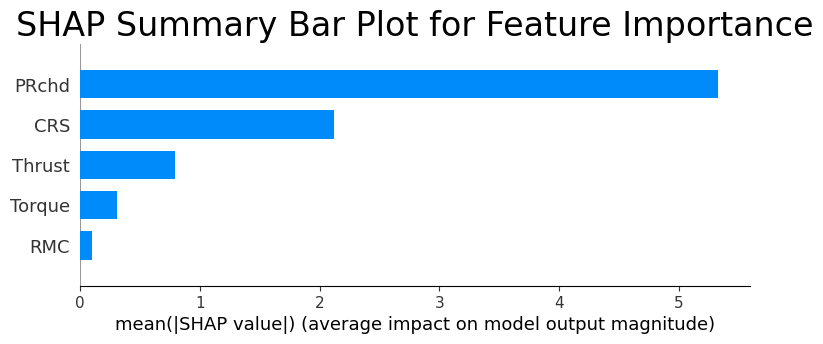

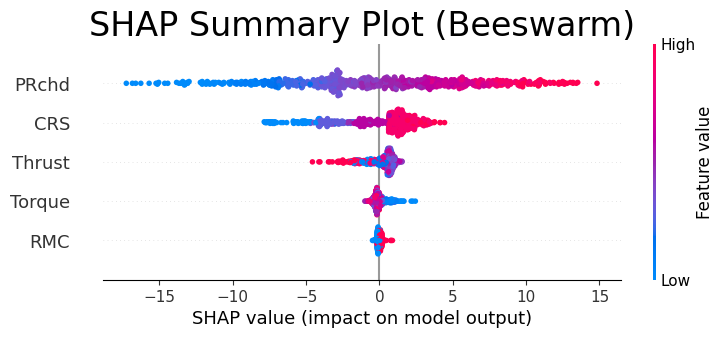


Predictions DataFrame (Entire Dataset):


,CRS,Torque,PRchd,Thrust,RMC,Actual_PRnet,Predicted_PRnet_SVR,Predicted_PRnet_Decision Tree,Predicted_PRnet_KNN,Predicted_PRnet_Random Forest
0,5.0,415.0,8.0,4118.0,1.0,40.0,39.972230,40.100000,41.46,43.150984
1,4.5,387.0,7.3,5084.0,1.0,32.4,32.499511,33.566667,37.20,39.188479
2,5.0,586.0,7.1,7345.0,1.0,36.0,35.485972,35.833333,36.29,38.349156
3,5.5,407.0,7.8,6004.0,1.0,42.8,42.884499,42.600000,47.40,44.248509
4,4.5,460.0,7.9,7152.0,1.0,36.0,35.900001,36.000000,39.87,43.090347


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Dataset Size: 3173 rows

Feature-Target Correlations:
PRnet     1.000000
PRchd     0.800817
RMC       0.146463
CRS       0.034063
Torque   -0.211709
Thrust   -0.285579
Name: PRnet, dtype: float64


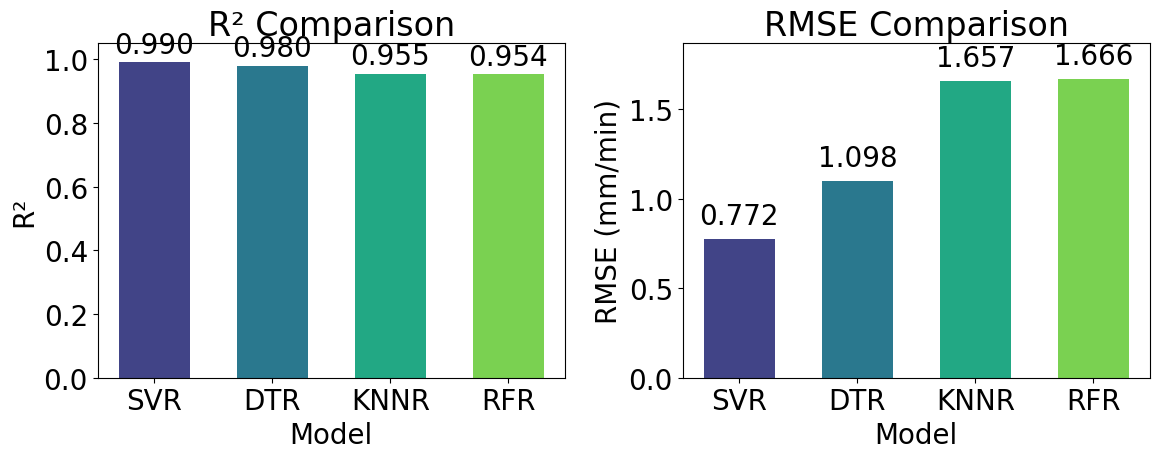

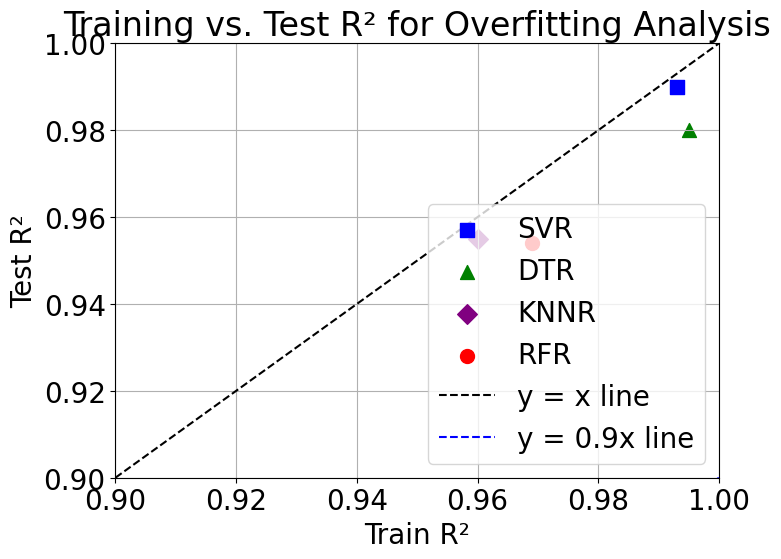

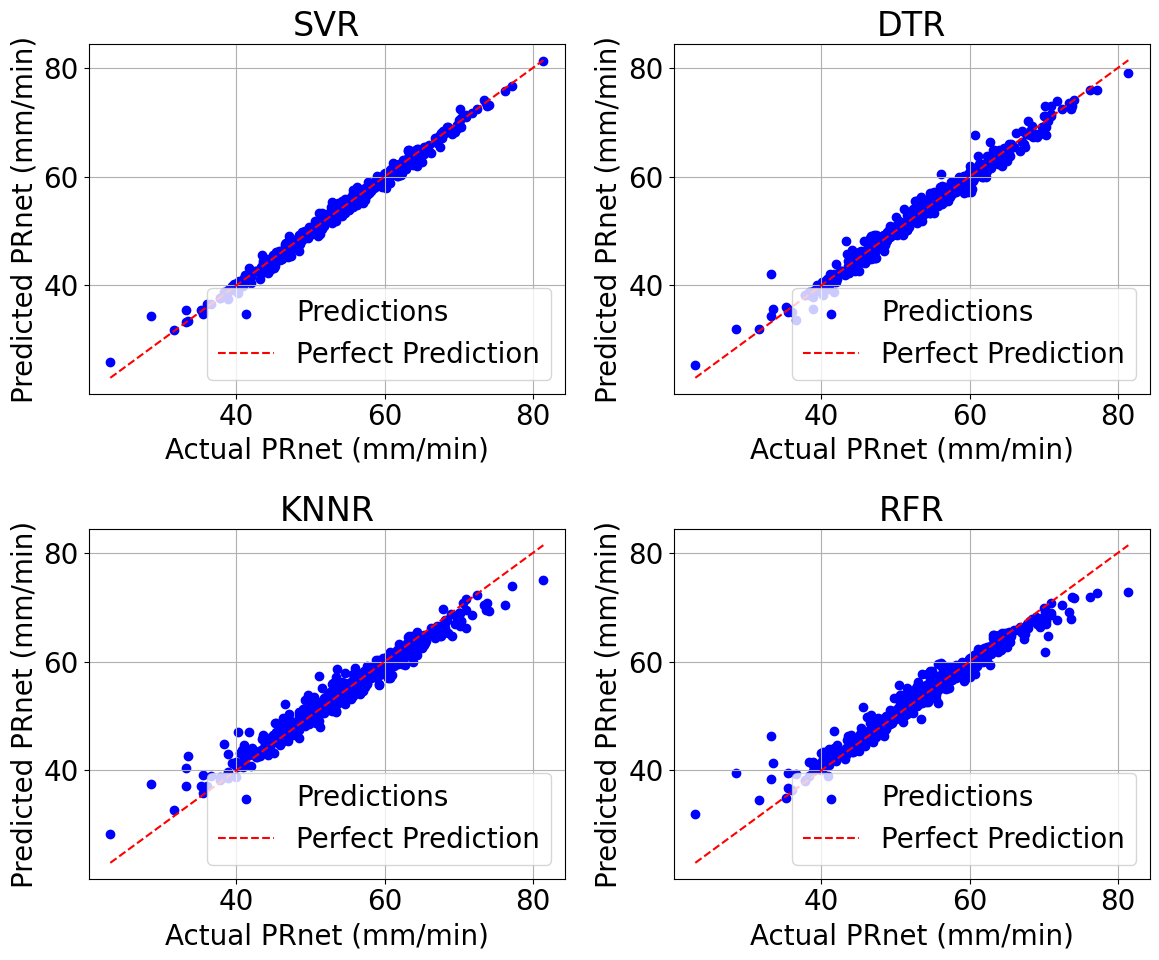

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary Libraries
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, label_binarize
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files
import joblib

# Set global font size for all plots
plt.rcParams.update({'font.size': 20})

# Load the Excel file from Google Drive
file_path = '/content/drive/My Drive/predictions23march_rmc.xlsx'
data = pd.read_excel(file_path)
print("Original columns:", data.columns)

# Drop the "RMR" column
data = data.drop(columns=['RMR'])
print("Columns after dropping RMR:", data.columns)

# Define features and target
X = data[['CRS', 'Torque', 'PRchd', 'Thrust', 'RMC']]
y = data['PRnet']  # PRnet is in mm/min

# Label encoding for categorical columns
label_encoder = LabelEncoder()
X = X.copy()
for col in ['RMC']:
    X[col] = label_encoder.fit_transform(X[col])
print("Preprocessed X head:\n", X.head())

# Save the label encoder for deployment
joblib.dump(label_encoder, 'label_encoder.pkl')

# Normalize features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🔹 Use Best Hyperparameters
best_params = {
    "SVR": {'C': 40, 'gamma': 'auto', 'kernel': 'rbf'},
    "Decision Tree": {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5},
    "KNN": {'algorithm': 'auto', 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'},
    "Random Forest": {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
}

# Initialize models with best hyperparameters
models = {
    "SVR": SVR(**best_params["SVR"]),
    "Decision Tree": DecisionTreeRegressor(**best_params["Decision Tree"]),
    "KNN": KNeighborsRegressor(**best_params["KNN"]),
    "Random Forest": RandomForestRegressor(**best_params["Random Forest"])
}

# 🔹 Cross-Validation Check (10-fold CV)
print("\nCross-Validated R² Scores (10-fold CV):")
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=10, scoring='r2')
    print(f"{name}: {np.mean(scores):.3f} (±{np.std(scores):.3f})")

# 🔹 Train and Evaluate Best Models on the Test Set
results = {
    "Model": [],
    "R²": [],
    "Adjusted R²": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "RRMSE": [],
    "MAPE": [],
    "MRE": [],
    "VAF": []
}

# Dictionary to store predictions for each model (on the entire dataset)
predictions_dict = {
    "Actual_PRnet": y.values
}

# Dictionary to store test predictions for actual vs. predicted plot
test_predictions = {}

# Function to calculate Adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else np.nan

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions on the test set for evaluation
    y_pred_test = model.predict(X_test)

    # Compute Metrics (on the test set)
    r2 = r2_score(y_test, y_pred_test)
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2 = adjusted_r2(r2, n, p)

    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    rrmse = rmse / np.mean(y_test) if np.mean(y_test) != 0 else np.nan
    mape = np.mean(np.abs((y_test - y_pred_test) / (y_test + 1e-10))) * 100
    mre = np.mean(np.abs(y_test - y_pred_test) / (np.abs(y_test) + np.abs(y_pred_test) + 1e-10)) * 100
    vaf = (1 - np.var(y_test - y_pred_test) / np.var(y_test)) * 100

    # Store Results (for test set evaluation)
    results["Model"].append(name)
    results["R²"].append(round(r2, 3))
    results["Adjusted R²"].append(round(adj_r2, 3))
    results["MAE"].append(round(mae, 3))
    results["MSE"].append(round(mse, 3))
    results["RMSE"].append(round(rmse, 3))
    results["RRMSE"].append(round(rrmse, 3))
    results["MAPE"].append(round(mape, 3))
    results["MRE"].append(round(mre, 3))
    results["VAF"].append(round(vaf, 3))

    # Predictions on the entire dataset
    y_pred_all = model.predict(X_scaled)

    # Store predictions in the dictionary (for the entire dataset)
    predictions_dict[f"Predicted_PRnet_{name}"] = y_pred_all

    # Store test predictions for actual vs. predicted plot
    test_predictions[name] = y_pred_test

# Convert results to a DataFrame and display (test set evaluation)
results_df = pd.DataFrame(results)
# Update model names for plotting
results_df['Model'] = results_df['Model'].replace({
    'SVR': 'SVR',
    'Decision Tree': 'DTR',
    'KNN': 'KNNR',
    'Random Forest': 'RFR'
})
print("\nTest Set Evaluation Metrics:")
display(results_df)

# 🔹 Evaluate Training and Testing Accuracy to Check for Overfitting
train_test_results = {
    "Model": [],
    "Train R²": [],
    "Test R²": [],
    "Train MAE": [],
    "Test MAE": [],
    "Train MSE": [],
    "Test MSE": [],
    "Train RMSE": [],
    "Test RMSE": []
}

for name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)

    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)

    train_test_results["Model"].append(name)
    train_test_results["Train R²"].append(round(train_r2, 3))
    train_test_results["Test R²"].append(round(test_r2, 3))
    train_test_results["Train MAE"].append(round(train_mae, 3))
    train_test_results["Test MAE"].append(round(test_mae, 3))
    train_test_results["Train MSE"].append(round(train_mse, 3))
    train_test_results["Test MSE"].append(round(test_mse, 3))
    train_test_results["Train RMSE"].append(round(train_rmse, 3))
    train_test_results["Test RMSE"].append(round(test_rmse, 3))

train_test_df = pd.DataFrame(train_test_results)
# Update model names for plotting
train_test_df['Model'] = train_test_df['Model'].replace({
    'SVR': 'SVR',
    'Decision Tree': 'DTR',
    'KNN': 'KNNR',
    'Random Forest': 'RFR'
})
print("\nTraining vs. Testing Metrics (to Check for Overfitting):")
display(train_test_df)

print("\nOverfitting Analysis:")
for index, row in train_test_df.iterrows():
    r2_diff = row["Train R²"] - row["Test R²"]
    print(f"{row['Model']}:")
    print(f"  R² Difference (Train - Test): {r2_diff:.3f}")
    if r2_diff > 0.1:
        print("  - Potential overfitting: Training R² is significantly higher than Test R².")
    elif r2_diff > 0.05:
        print("  - Mild overfitting: Training R² is slightly higher than Test R².")
    else:
        print("  - No significant overfitting: Training and Test R² are close.")
    print(f"  RMSE Difference (Test - Train): {row['Test RMSE'] - row['Train RMSE']:.3f}")
    print()

# 🔹 Feature Importance for Random Forest
rf = models["Random Forest"]
rf.fit(X_train, y_train)
importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
print("\nRandom Forest Feature Importances:")
print(importances.sort_values('Importance', ascending=False))

# 🔹 SHAP Analysis for Random Forest
explainer = shap.TreeExplainer(models["Random Forest"])
shap_values = explainer.shap_values(X_test)

# SHAP Summary Bar Plot (Figure 7-5)
plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Summary Bar Plot for Feature Importance")
plt.savefig('figure_7_5_shap_bar.png', dpi=800)
plt.show()

# SHAP Summary Plot (Beeswarm Plot, Figure 7-6)
plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot (Beeswarm)")
plt.savefig('figure_7_6_shap_beeswarm.png', dpi=800)
plt.show()

# 🔹 Create a DataFrame with actual and predicted PRnet values
predictions_df = pd.DataFrame(predictions_dict)
predictions_df.index = y.index

X_original = scaler.inverse_transform(X_scaled)
X_df = pd.DataFrame(X_original, columns=X.columns, index=y.index)
predictions_df = pd.concat([X_df, predictions_df], axis=1)

print("\nPredictions DataFrame (Entire Dataset):")
display(predictions_df.head())

# 🔹 Save the best model (SVR), scaler, and label encoder for deployment
best_model = models["SVR"]
joblib.dump(best_model, 'best_model_svr.pkl')
joblib.dump(scaler, 'scaler.pkl')
files.download('best_model_svr.pkl')
files.download('scaler.pkl')
files.download('label_encoder.pkl')

predictions_file = 'predicted_penetration_rates_actual.xlsx'
predictions_df.to_excel(predictions_file, index=True)
files.download(predictions_file)

# Additional Check: Dataset Size and Correlations
print(f"\nDataset Size: {len(data)} rows")
print("\nFeature-Target Correlations:")
X_with_target = X.copy()
X_with_target['PRnet'] = y
print(X_with_target.corr()['PRnet'].sort_values(ascending=False))

# 🔹 Visualizations for Report

# Figure 7-3: Comparison of R² and RMSE (Model on x-axis, R² and RMSE on y-axis)
plt.figure(figsize=(12, 5))

# R² Comparison
plt.subplot(1, 2, 1)
bars = plt.bar(results_df['Model'], results_df['R²'], color=sns.color_palette('viridis', len(results_df)), width=0.6)
plt.title('R² Comparison')
plt.xlabel('Model')
plt.ylabel('R²')
plt.ylim(0, 1.05)  # Adjusted to ensure values fit within plot
# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

# RMSE Comparison
plt.subplot(1, 2, 2)
bars = plt.bar(results_df['Model'], results_df['RMSE'], color=sns.color_palette('viridis', len(results_df)), width=0.6)
plt.title('RMSE Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE (mm/min)')  # Updated unit to mm/min
plt.ylim(0, max(results_df['RMSE']) + 0.2)  # Adjusted to ensure values fit within plot
# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('figure_7_3_comparison.png', dpi=800)
plt.show()

# Figure 7-4: Training vs. Test R² (Scatter Plot like the provided example)
plt.figure(figsize=(8, 6))
markers = {'SVR': 's', 'DTR': '^', 'KNNR': 'D', 'RFR': 'o'}  # Different markers for each model
colors = {'SVR': 'blue', 'DTR': 'green', 'KNNR': 'purple', 'RFR': 'red'}  # Different colors for each model

# Plot scatter points for each model
for idx, row in train_test_df.iterrows():
    plt.scatter(row['Train R²'], row['Test R²'], label=row['Model'], s=100, marker=markers[row['Model']], color=colors[row['Model']])

# Plot y=x line
plt.plot([0.9, 1.0], [0.9, 1.0], 'k--', label='y = x line')
# Plot y=0.9x line
plt.plot([0.9, 1.0], [0.81, 0.9], 'b--', label='y = 0.9x line')

plt.xlabel('Train R²')
plt.ylabel('Test R²')
plt.title('Training vs. Test R² for Overfitting Analysis')
plt.xlim(0.9, 1.0)
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('figure_7_4_overfitting.png', dpi=800)
plt.show()

# Figure 7-7: Actual vs. Predicted PRnet for All Models (2x2 Subplot)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
model_names = {'SVR': 'SVR', 'Decision Tree': 'DTR', 'KNN': 'KNNR', 'Random Forest': 'RFR'}

for idx, (name, y_pred) in enumerate(test_predictions.items()):
    axes[idx].scatter(y_test, y_pred, color='blue', label='Predictions')
    axes[idx].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    axes[idx].set_title(model_names[name])
    axes[idx].set_xlabel('Actual PRnet (mm/min)')  # Updated unit to mm/min
    axes[idx].set_ylabel('Predicted PRnet (mm/min)')  # Updated unit to mm/min
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.savefig('figure_7_7_actual_vs_predicted.png', dpi=800)
plt.show()

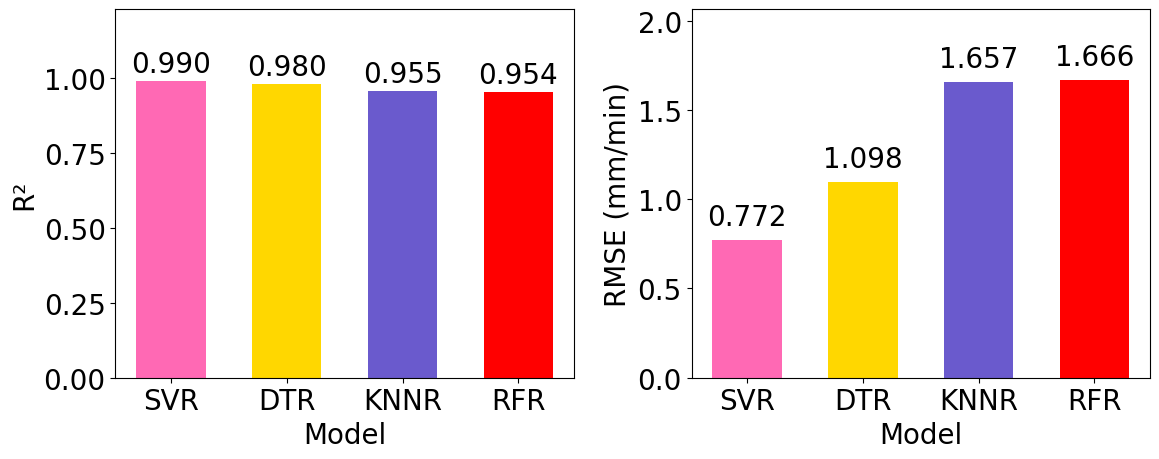

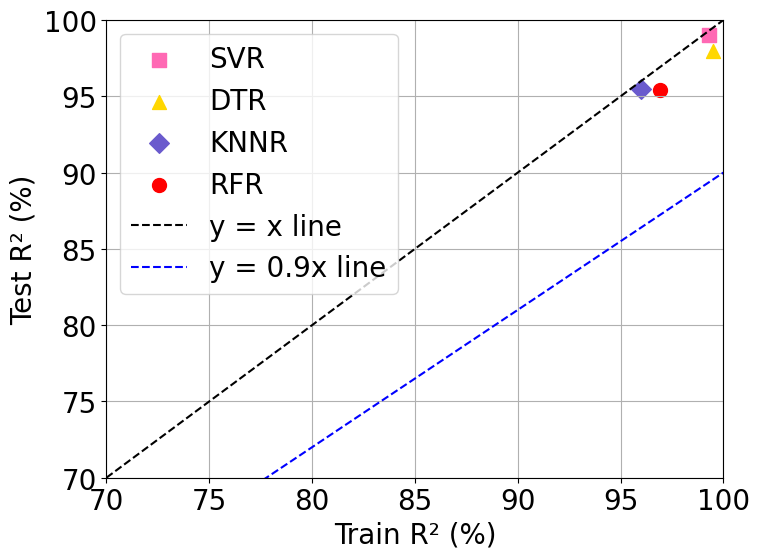

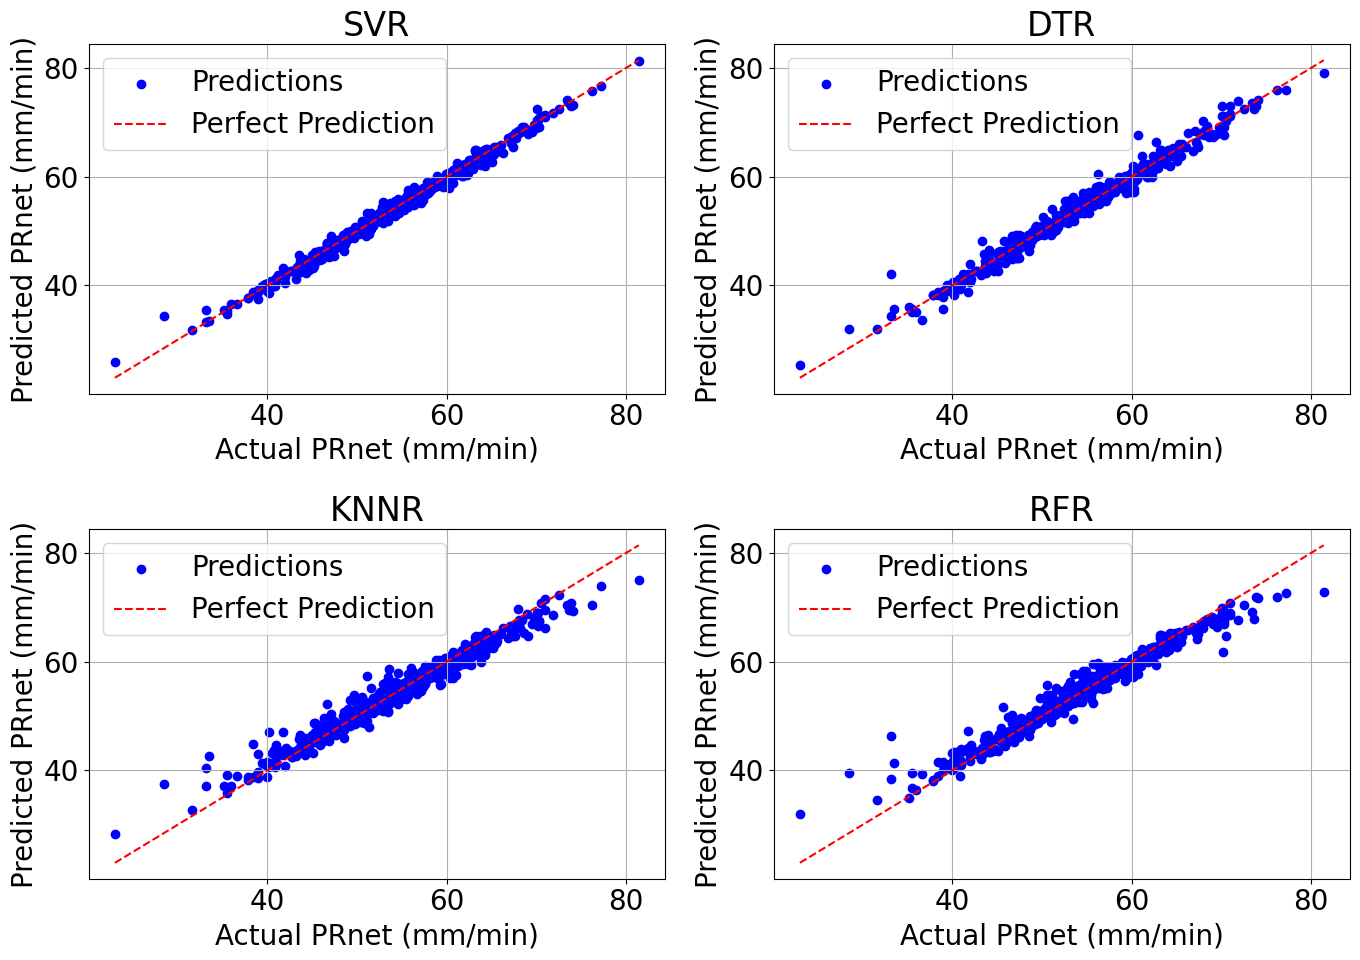

In [ ]:
# Figure 7-3: Comparison of R² and RMSE (Model on x-axis, R² and RMSE on y-axis)
plt.figure(figsize=(12, 5))
# Define colors consistent with scatter plot
colors = {'SVR': 'hotpink', 'DTR': 'gold', 'KNNR': 'slateblue', 'RFR': 'red'}

# R² Comparison
plt.subplot(1, 2, 1)
bars = plt.bar(results_df['Model'], results_df['R²'],
               color=[colors[model] for model in results_df['Model']],
               width=0.6)
plt.title('')
plt.xlabel('Model')
plt.ylabel('R²')
plt.ylim(0, 1.23)  # Adjusted to ensure values fit within plot
# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

# RMSE Comparison
plt.subplot(1, 2, 2)
bars = plt.bar(results_df['Model'], results_df['RMSE'],
               color=[colors[model] for model in results_df['Model']],
               width=0.6)
plt.title('')
plt.xlabel('Model')
plt.ylabel('RMSE (mm/min)')  # Updated unit to mm/min
plt.ylim(0, max(results_df['RMSE']) + 0.4)  # Adjusted to ensure values fit within plot
# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('figure_7_3_comparison.png', dpi=800)
plt.show()

# Figure 7-4: Training vs. Test R² (Scatter Plot like the provided example)
plt.figure(figsize=(8, 6))
markers = {'SVR': 's', 'DTR': '^', 'KNNR': 'D', 'RFR': 'o'}  # Different markers for each model

# Convert R² values to percentages for plotting (e.g., 0.9 becomes 90%)
train_test_df['Train R² (%)'] = train_test_df['Train R²'] * 100
train_test_df['Test R² (%)'] = train_test_df['Test R²'] * 100

# Plot scatter points for each model
for idx, row in train_test_df.iterrows():
    plt.scatter(row['Train R² (%)'], row['Test R² (%)'],
                label=row['Model'],
                s=100,
                marker=markers[row['Model']],
                color=colors[row['Model']])

# Plot y=x line
plt.plot([70, 100], [70, 100], 'k--', label='y = x line')
# Plot y=0.9x line
plt.plot([70, 100], [63, 90], 'b--', label='y = 0.9x line')

plt.xlabel('Train R² (%)')
plt.ylabel('Test R² (%)')
plt.title('')
plt.xlim(70, 100)
plt.ylim(70, 100)
plt.legend(loc='upper left')  # Changed to top left
plt.grid(True)
plt.tight_layout()
plt.savefig('figure_7_4_overfitting.png', dpi=800)
plt.show()

# Figure 7-7: Actual vs. Predicted PRnet for All Models (2x2 Subplot)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
model_names = {'SVR': 'SVR', 'Decision Tree': 'DTR', 'KNN': 'KNNR', 'Random Forest': 'RFR'}

for idx, (name, y_pred) in enumerate(test_predictions.items()):
    axes[idx].scatter(y_test, y_pred, color='blue', label='Predictions')
    axes[idx].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
                  color='red', linestyle='--', label='Perfect Prediction')
    axes[idx].set_title(model_names[name])
    axes[idx].set_xlabel('Actual PRnet (mm/min)')  # Updated unit to mm/min
    axes[idx].set_ylabel('Predicted PRnet (mm/min)')  # Updated unit to mm/min
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.savefig('figure_7_7_actual_vs_predicted.png', dpi=800)
plt.show()